<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fhybrid-models/models/base_models_gnn_convlstm_stacking_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/main/models/base_models_gnn_convlstm_stacking_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# V5 GNN-ConvLSTM Stacking: Meta-Learner Ensemble for Spatiotemporal Precipitation Prediction

## Novel Hybrid Architecture - Dual-Branch Stacking with Interpretable Meta-Learner

**Version:** 5.0  
**Date:** January 2026  
**Author:** Manuel Perez  
**Institution:** UPTC - Doctoral Thesis in Engineering  

---

### Architecture Overview

V5 combines the complementary strengths of V2 (ConvLSTM) and V4 (GNN-TAT) through a stacking ensemble:

| Component | Description | Innovation |
|-----------|-------------|------------|
| **Branch 1: ConvLSTM** | Euclidean spatial patterns (BASIC features) | Local spatiotemporal extraction |
| **Branch 2: GNN-TAT** | Non-Euclidean topographic relations (KCE features) | Graph-based orographic modeling |
| **Grid-Graph Fusion** | Cross-attention between representations | Novel grid-graph alignment |
| **Meta-Learner** | Interpretable weighted fusion | Context-dependent branch weighting |

### Target Performance (from spec.md)

| Metric | V4 Baseline | V5 Target | V5 Excellent |
|--------|-------------|-----------|---------------|
| R^2 (H1-H6) | 0.628 | > 0.65 | > 0.70 |
| RMSE (mm) | 92.12 | < 85 | < 80 |
| Parameters | 98K | < 200K | < 180K |

### Innovation Status
**NOVEL CONTRIBUTION:** No existing Q1 publications combine GNN and ConvLSTM in stacking ensemble for precipitation prediction (verified January 2026).

## 1. Environment Setup and Imports

In [1]:
# =============================================================================
# SECTION 1.1: ENVIRONMENT DETECTION AND SETUP
# =============================================================================

import os
import sys
from pathlib import Path

# Detect environment
IN_COLAB = 'google.colab' in sys.modules
print(f"Running in Google Colab: {IN_COLAB}")

if IN_COLAB:
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Install required packages (match PyTorch/CUDA build)
    import torch

    torch_version = torch.__version__.split('+')[0]
    cuda_version = torch.version.cuda
    if cuda_version:
        cuda_tag = f"cu{cuda_version.replace('.', '')}"
    else:
        cuda_tag = "cpu"
    pyg_url = f"https://data.pyg.org/whl/torch-{torch_version}+{cuda_tag}.html"
    print(f"Installing PyG wheels from: {pyg_url}")
    !pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f {pyg_url}
    !pip install -q netCDF4 xarray dask h5netcdf

    # Set base paths for Colab
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')
    DRIVE_DATA_FILE = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc'
    LOCAL_DATA_FILE = Path('/content/complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc')
    OUTPUT_ROOT = BASE_PATH / 'models' / 'output' / 'V5_GNN_ConvLSTM_Stacking'

    # Copy dataset to local for faster access
    if not LOCAL_DATA_FILE.exists():
        !cp "{DRIVE_DATA_FILE}" "{LOCAL_DATA_FILE}"
        print("Dataset copied to local storage for faster access")
    DATA_FILE = LOCAL_DATA_FILE
else:
    # Local paths
    BASE_PATH = Path('d:/github.com/ninja-marduk/ml_precipitation_prediction')
    DATA_FILE = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc'
    OUTPUT_ROOT = BASE_PATH / 'models' / 'output' / 'V5_GNN_ConvLSTM_Stacking'

# Create output directories
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {OUTPUT_ROOT}")


Running in Google Colab: True
Mounted at /content/drive
Installing PyG wheels from: https://data.pyg.org/whl/torch-2.9.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.5 MB/s eta 0:00:00
Dataset copied to local storage for faster access
Output directory: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V5_GNN_ConvLSTM_

In [2]:
# =============================================================================
# SECTION 1.2: IMPORTS
# =============================================================================

import json
import gc
import copy
import warnings
from datetime import datetime
from dataclasses import dataclass, field, asdict
from typing import Dict, List, Tuple, Optional, Any

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import geopandas as gpd
except ImportError:
    gpd = None

try:
    import imageio.v2 as imageio
except ImportError:
    imageio = None


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# PyTorch Geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import Data, Batch

from sklearn.cluster import KMeans
from scipy import stats

warnings.filterwarnings('ignore')

# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


Using device: cuda
GPU: NVIDIA H100 80GB HBM3
GPU Memory: 85.2 GB


## 2. Configuration

In [3]:
# =============================================================================
# SECTION 2: V5 CONFIGURATION (from spec.md Section 3.3)
# =============================================================================

@dataclass
class V5Config:
    """Complete V5 GNN-ConvLSTM Stacking configuration."""

    # Data configuration
    input_window: int = 60      # Input months
    horizon: int = 12           # Prediction months
    train_val_split: float = 0.8

    # Light mode for testing
    light_mode: bool = False     # Set to False for full grid
    light_grid_size: int = 5    # Grid subset size when light_mode=True

    # Enabled horizons for experiments
    enabled_horizons: List[int] = field(default_factory=lambda: [12])

    # Branch 1: ConvLSTM configuration (V2 Enhanced)
    convlstm_filters: List[int] = field(default_factory=lambda: [32, 16])
    convlstm_kernel_size: int = 3
    convlstm_attention: bool = True
    convlstm_bidirectional: bool = True
    convlstm_residual: bool = True
    convlstm_output_dim: int = 64

    # Branch 2: GNN-TAT configuration (V4)
    gnn_type: str = 'GAT'           # GAT, SAGE, or GCN
    gnn_hidden_dim: int = 64
    gnn_num_layers: int = 2
    gnn_num_heads: int = 4          # For GAT
    gnn_temporal_heads: int = 4
    gnn_lstm_hidden: int = 64
    gnn_lstm_layers: int = 2
    gnn_output_dim: int = 64
    gnn_dropout: float = 0.1

    # Graph construction
    edge_threshold: float = 0.3
    max_neighbors: int = 8
    use_distance_edges: bool = True
    use_elevation_edges: bool = True
    use_correlation_edges: bool = True
    distance_scale_km: float = 10.0
    elevation_weight: float = 0.3
    correlation_weight: float = 0.5
    elevation_scale_m: float = 500.0
    min_edge_weight: float = 0.01

    # Grid-Graph Fusion
    fusion_type: str = 'auto'       # cross_attention, gated, or auto
    fusion_heads: int = 4
    fusion_hidden_dim: int = 64
    fusion_dropout: float = 0.1
    fusion_max_nodes: int = 1024

    # Meta-Learner
    meta_hidden_dim: int = 128
    meta_dropout: float = 0.1
    meta_use_context_features: bool = True
    meta_context_features: List[str] = field(
        default_factory=lambda: ['mean_elevation', 'elevation_cluster', 'temporal_regime']
    )

    # Training
    epochs: int = 200
    batch_size: int = 4
    learning_rate: float = 0.0005
    weight_decay: float = 1e-4
    patience: int = 60
    gradient_clip: float = 1.0

    # Export/visualization alignment
    export_predictions: bool = True
    generate_map_plots: bool = True
    map_cycle_all_val_windows: bool = False
    map_sample_index: int = -1
    map_export_dpi: int = 300
    map_gif_duration: float = 1.5
    plot_graph_diagnostics: bool = True

    # Quality checks / gates
    max_bias_pct: float = 10.0
    max_scale_ratio: float = 50.0
    max_negative_frac: float = 0.001
    min_branch_weight: float = 0.05
    param_budget: int = 200000
    enforce_quality_gates: bool = False
    allow_missing_features: bool = False
    allow_overlap_windows: bool = False
    correlation_train_only: bool = True

# Initialize config
CONFIG = V5Config()

# Run-mode overrides
RUN_FULL_DATASET = True  # Set False for quick smoke tests
if RUN_FULL_DATASET:
    CONFIG.light_mode = False
    CONFIG.enabled_horizons = [12]
    CONFIG.horizon = 12

print("V5 Configuration initialized:")
print(f"  - Light mode: {CONFIG.light_mode}")
print(f"  - GNN type: {CONFIG.gnn_type}")
print(f"  - Enabled horizons: {CONFIG.enabled_horizons}")
print(f"  - Epochs: {CONFIG.epochs}")
print(f"  - Fusion type: {CONFIG.fusion_type}")


V5 Configuration initialized:
  - Light mode: False
  - GNN type: GAT
  - Enabled horizons: [12]
  - Epochs: 200
  - Fusion type: auto


## 3. Data Loading and Validation

In [4]:
# =============================================================================
# SECTION 3: DATA LOADING AND FEATURE EXTRACTION
# =============================================================================

# Feature set definitions (from CLAUDE.md Section 8)
FEATURE_SETS = {
    'BASIC': [
        'year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
        'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
        'elevation', 'slope', 'aspect'
    ],
    'KCE': [
        'year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
        'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
        'elevation', 'slope', 'aspect',
        'elev_high', 'elev_med', 'elev_low'
    ],
    'PAFC': [
        'year', 'month', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
        'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std',
        'elevation', 'slope', 'aspect',
        'elev_high', 'elev_med', 'elev_low',
        'total_precipitation_lag1', 'total_precipitation_lag2', 'total_precipitation_lag12'
    ]
}

def _resolve_dim(ds: xr.Dataset, candidates: Tuple[str, ...]) -> str:
    for name in candidates:
        if name in ds.dims:
            return name
    raise ValueError(f"Missing required dimension. Expected one of: {candidates}")


def _required_features(feature_sets: Dict[str, List[str]]) -> List[str]:
    required = set()
    for name in feature_sets['BASIC'] + feature_sets['KCE']:
        if name.startswith('elev_'):
            continue
        required.add(name)
    required.add('total_precipitation')
    return sorted(required)


def validate_dataset(ds: xr.Dataset, config: V5Config, feature_sets: Dict[str, List[str]]) -> Tuple[str, str]:
    if 'time' not in ds.dims:
        raise ValueError("Dataset missing required 'time' dimension")

    lat_dim = _resolve_dim(ds, ('latitude', 'lat'))
    lon_dim = _resolve_dim(ds, ('longitude', 'lon'))

    missing = [name for name in _required_features(feature_sets)
               if name not in ds.data_vars and name not in ds.coords]
    if missing:
        raise ValueError(f"Missing required variables: {missing}")

    n_time = int(ds.dims['time'])
    if n_time < config.input_window + config.horizon:
        raise ValueError(
            f"Not enough timesteps: {n_time} < {config.input_window + config.horizon}"
        )

    return lat_dim, lon_dim


def load_dataset(data_path: Path, config: V5Config) -> xr.Dataset:
    """Load and validate the NetCDF dataset."""
    print(f"Loading dataset from: {data_path}")
    ds = xr.open_dataset(data_path)

    lat_dim, lon_dim = validate_dataset(ds, config, FEATURE_SETS)

    # Print dataset info
    print(f"\nDataset dimensions:")
    for dim, size in ds.dims.items():
        print(f"  - {dim}: {size}")

    print(f"\nAvailable variables: {list(ds.data_vars)}")

    # Apply light mode if enabled
    if config.light_mode:
        lat_slice = slice(0, config.light_grid_size)
        lon_slice = slice(0, config.light_grid_size)
        ds = ds.isel({lat_dim: lat_slice, lon_dim: lon_slice})
        print(f"\nLight mode enabled: using {config.light_grid_size}x{config.light_grid_size} grid")

    return ds


def create_elevation_clusters(ds: xr.Dataset, n_clusters: int = 3) -> xr.Dataset:
    """Add elevation cluster features (KCE) to dataset."""
    elevation = ds['elevation'].values
    elev_dims = ds['elevation'].dims

    # Handle 3D elevation (time, lat, lon) by taking first timestep
    if elevation.ndim == 3:
        print("Handling 3D elevation: using first timestep for static clustering")
        elevation = elevation[0]
        elev_dims = elev_dims[-2:]

    valid_mask = ~np.isnan(elevation)

    # Flatten for clustering
    elev_flat = elevation[valid_mask].reshape(-1, 1)

    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED, n_init=10)
    labels = np.full(elevation.shape, -1)
    labels[valid_mask] = kmeans.fit_predict(elev_flat)

    # Create one-hot encoded features
    for i, name in enumerate(['elev_low', 'elev_med', 'elev_high']):
        cluster_data = np.zeros_like(elevation)
        cluster_data[labels == i] = 1.0
        ds[name] = xr.DataArray(
            data=cluster_data,
            dims=elev_dims,
            attrs={'description': f'Elevation cluster {name}'}
        )

    print("Added elevation clusters: elev_low, elev_med, elev_high")
    return ds


def extract_features(ds: xr.Dataset, feature_names: List[str], config: V5Config) -> Tuple[np.ndarray, List[str]]:
    """Extract features from dataset into numpy array."""
    features = []
    missing = []

    for name in feature_names:
        if name in ds.data_vars:
            data = ds[name].values
            # Handle different dimensions
            if data.ndim == 2:  # (lat, lon) - static features
                # Broadcast to (time, lat, lon)
                data = np.broadcast_to(data, (ds.dims['time'], *data.shape))
            features.append(data)
        else:
            missing.append(name)

    if missing:
        msg = f"Missing features: {missing}"
        if config.allow_missing_features:
            print(f"Warning: {msg}")
        else:
            raise ValueError(msg)

    if not features:
        raise ValueError("No features extracted; check dataset and feature list")

    # Stack features: (time, lat, lon, n_features)
    features = np.stack(features, axis=-1)
    features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    print(f"Extracted features shape: {features.shape}")

    return features.astype(np.float32), missing

# Load dataset
ds = load_dataset(DATA_FILE, CONFIG)
LAT_DIM = _resolve_dim(ds, ('latitude', 'lat'))
LON_DIM = _resolve_dim(ds, ('longitude', 'lon'))
ds = create_elevation_clusters(ds)


Loading dataset from: /content/complete_dataset_with_features_with_clusters_elevation_windows_imfs_with_onehot_elevation_clean.nc

Dataset dimensions:
  - time: 518
  - latitude: 61
  - longitude: 65

Available variables: ['total_precipitation', 'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'year', 'month', 'elevation', 'slope', 'aspect', 'cluster_elevation', 'total_precipitation_lag1', 'total_precipitation_lag2', 'total_precipitation_lag3', 'total_precipitation_lag4', 'total_precipitation_lag12', 'total_precipitation_lag24', 'total_precipitation_lag36', 'CEEMDAN_imf_1', 'CEEMDAN_imf_2', 'CEEMDAN_imf_3', 'CEEMDAN_imf_4', 'CEEMDAN_imf_5', 'CEEMDAN_imf_6', 'CEEMDAN_imf_7', 'CEEMDAN_imf_8', 'CEEMDAN_imf_9', 'TVFEMD_imf_1', 'TVFEMD_imf_2', 'TVFEMD_imf_3', 'TVFEMD_imf_4', 'TVFEMD_imf_5', 'TVFEMD_imf_6', 'TVFEMD_imf_7', 'TVFEMD_imf_8', 'elev_low', 'elev_med', 'elev_high']
Handling 3D elevation: using first tim

## 4. Graph Construction for GNN Branch

In [5]:
# =============================================================================
# SECTION 4: GRAPH CONSTRUCTION
# =============================================================================

class SpatialGraphBuilder:
    """Build spatial graph for GNN branch based on geographic and topographic similarity."""

    def __init__(self, config: V5Config):
        self.config = config

    @staticmethod
    def _safe_correlation(ts_a: np.ndarray, ts_b: np.ndarray) -> float:
        """Compute correlation robustly (returns 0.0 for invalid cases)."""
        mask = np.isfinite(ts_a) & np.isfinite(ts_b)
        if mask.sum() < 2:
            return 0.0
        a = ts_a[mask]
        b = ts_b[mask]
        a = a - a.mean()
        b = b - b.mean()
        denom = np.sqrt(np.sum(a * a)) * np.sqrt(np.sum(b * b))
        if denom < 1e-6:
            return 0.0
        corr = float(np.sum(a * b) / denom)
        if not np.isfinite(corr):
            return 0.0
        return corr

    @staticmethod
    def _get_coord(ds: xr.Dataset, names: List[str]) -> np.ndarray:
        for name in names:
            if name in ds.coords:
                return ds.coords[name].values
            if name in ds.variables:
                return ds[name].values
        raise KeyError(f"Missing coordinate; tried {names}")

    def build_graph(self, ds: xr.Dataset, train_time_idx: Optional[int] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """Build graph structure from dataset.

        Returns:
            edge_index: (2, num_edges) tensor of edge indices
            edge_weight: (num_edges,) tensor of edge weights
        """
        lat = self._get_coord(ds, ['lat', 'latitude'])
        lon = self._get_coord(ds, ['lon', 'longitude'])
        elevation = ds['elevation'].values

        if elevation.ndim == 3:
            elevation = elevation[0]

        n_lat, n_lon = len(lat), len(lon)
        n_nodes = n_lat * n_lon

        print(f"Building graph for {n_lat}x{n_lon} = {n_nodes} nodes")

        # Create node positions in km for distance scaling
        lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')
        mean_lat = float(np.mean(lat))
        km_per_deg_lat = 111.32
        km_per_deg_lon = 111.32 * np.cos(np.deg2rad(mean_lat))
        positions = np.stack(
            [lat_grid.flatten() * km_per_deg_lat, lon_grid.flatten() * km_per_deg_lon],
            axis=1
        )
        elev_flat = elevation.flatten()

        self.node_positions = positions
        self.node_elevations = elev_flat
        self.n_nodes = n_nodes

        # Precompute precipitation time series for correlation edges
        precip_flat = None
        if self.config.use_correlation_edges:
            precip = ds['total_precipitation'].values.astype(np.float32)
            if train_time_idx is not None:
                train_time_idx = max(2, min(train_time_idx, precip.shape[0]))
                precip = precip[:train_time_idx]
                print(f"Correlation edges using first {train_time_idx} timesteps")
            precip_flat = precip.reshape(precip.shape[0], n_nodes)

        edges = []
        weights = []

        distance_coeff = 1.0
        if self.config.use_elevation_edges or self.config.use_correlation_edges:
            distance_coeff = max(
                0.0,
                1.0 - self.config.elevation_weight - self.config.correlation_weight
            )

        for i in range(n_nodes):
            # Calculate distances to all other nodes
            distances = np.sqrt(np.sum((positions - positions[i])**2, axis=1))

            # Get k nearest neighbors (excluding self)
            distances[i] = np.inf
            nearest_idx = np.argsort(distances)[:self.config.max_neighbors]
            ts_i = precip_flat[:, i] if precip_flat is not None else None

            for j in nearest_idx:
                if distances[j] == np.inf:
                    continue

                component_weights = []

                if self.config.use_distance_edges:
                    dist_weight = np.exp(-distances[j] / self.config.distance_scale_km)
                    component_weights.append((dist_weight, distance_coeff))

                if self.config.use_elevation_edges:
                    if not np.isnan(elev_flat[i]) and not np.isnan(elev_flat[j]):
                        elev_diff = np.abs(elev_flat[i] - elev_flat[j])
                        elev_weight = np.exp(-elev_diff / self.config.elevation_scale_m)
                    else:
                        elev_weight = 0.5
                    component_weights.append((elev_weight, self.config.elevation_weight))

                if self.config.use_correlation_edges:
                    if precip_flat is not None:
                        corr = self._safe_correlation(ts_i, precip_flat[:, j])
                    else:
                        corr = 0.0
                    corr_weight = max(0.0, corr)
                    component_weights.append((corr_weight, self.config.correlation_weight))

                if not component_weights:
                    continue

                coeff_sum = sum(weight for _, weight in component_weights)
                if coeff_sum <= 0:
                    coeff_sum = len(component_weights)
                    combined_weight = sum(val for val, _ in component_weights) / coeff_sum
                else:
                    combined_weight = sum(val * weight for val, weight in component_weights) / coeff_sum

                threshold = max(self.config.edge_threshold, self.config.min_edge_weight)
                if combined_weight >= threshold:
                    edges.append([i, j])
                    weights.append(combined_weight)

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        edge_weight = torch.tensor(weights, dtype=torch.float32)

        print(f"Graph built: {n_nodes} nodes, {edge_index.shape[1]} edges")
        print(f"Average edges per node: {edge_index.shape[1] / n_nodes:.1f}")

        return edge_index, edge_weight

# Build graph
graph_builder = SpatialGraphBuilder(CONFIG)
train_time_idx = None
if CONFIG.use_correlation_edges and CONFIG.correlation_train_only:
    train_time_idx = int(ds.dims['time'] * CONFIG.train_val_split)
edge_index, edge_weight = graph_builder.build_graph(ds, train_time_idx=train_time_idx)
if edge_index.numel() == 0:
    raise ValueError("Graph construction produced zero edges")
print(f"Edge index shape: {edge_index.shape}")
print(f"Edge weight shape: {edge_weight.shape}")


Building graph for 61x65 = 3965 nodes
Correlation edges using first 414 timesteps
Graph built: 3965 nodes, 31720 edges
Average edges per node: 8.0
Edge index shape: torch.Size([2, 31720])
Edge weight shape: torch.Size([31720])


Graph visualization saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V5_GNN_ConvLSTM_Stacking/graph_visualization_v5.png


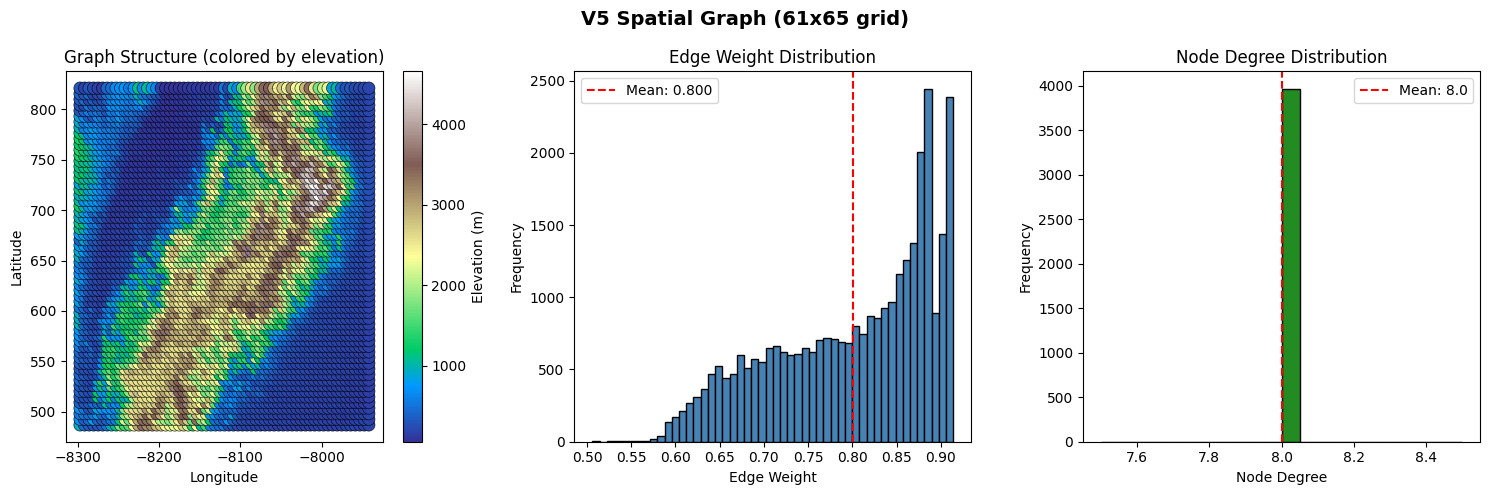

Edge analysis saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V5_GNN_ConvLSTM_Stacking/graph_edge_analysis_v5.png


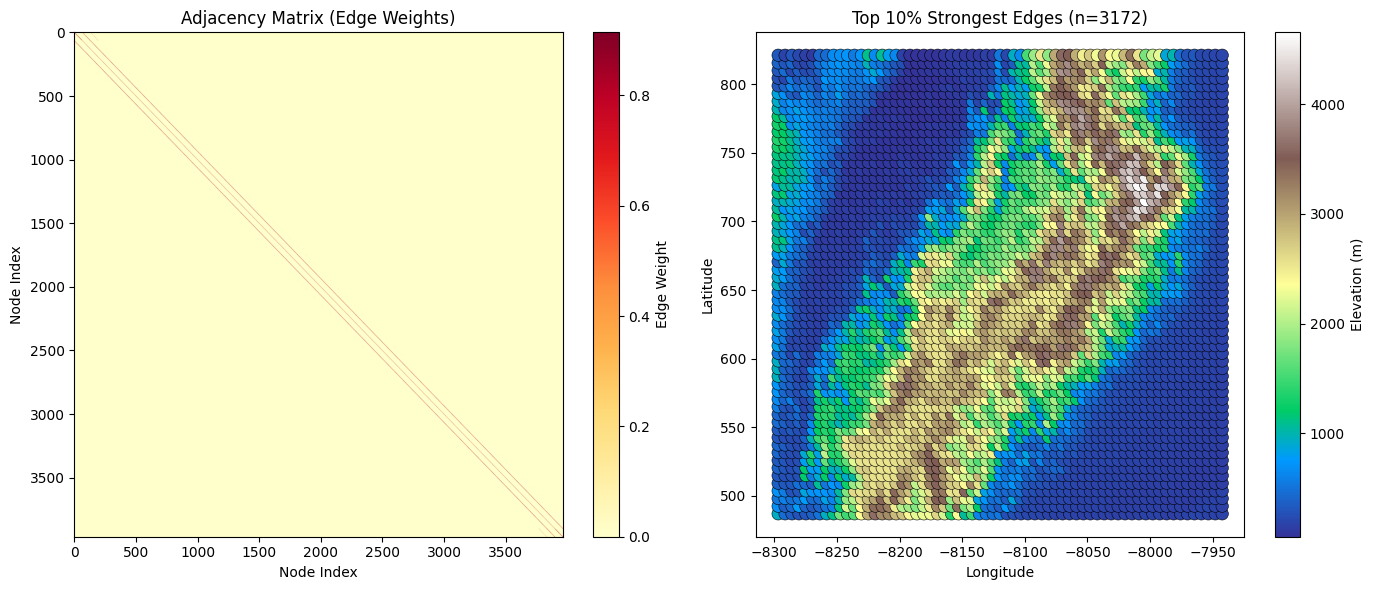

Graph Statistics:
  Total nodes: 3965
  Total edges: 31720
  Average edge weight: 0.8005
  Max edge weight: 0.9141
  Strong edges (top 10%): 3172


In [7]:
# =============================================================================
# SECTION 4.1: GRAPH DIAGNOSTICS (V4-COMPATIBLE)
# =============================================================================

def visualize_graph(graph_builder: SpatialGraphBuilder, edge_index: np.ndarray,
                   edge_weight: np.ndarray, title: str = 'Spatial Graph'):
    if edge_weight.size == 0:
        print('Graph visualization skipped: empty edge list')
        return

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    pos = graph_builder.node_positions
    n_edges_to_draw = min(500, len(edge_weight))
    edge_indices = np.random.choice(len(edge_weight), n_edges_to_draw, replace=False)
    for idx in edge_indices:
        i, j = edge_index[0, idx], edge_index[1, idx]
        ax1.plot([pos[i, 1], pos[j, 1]], [pos[i, 0], pos[j, 0]], 'b-', alpha=0.2, linewidth=0.5)

    scatter = ax1.scatter(pos[:, 1], pos[:, 0], c=graph_builder.node_elevations,
                         cmap='terrain', s=80, edgecolors='black', linewidth=0.4)
    plt.colorbar(scatter, ax=ax1, label='Elevation (m)')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title('Graph Structure (colored by elevation)')

    ax2 = axes[1]
    ax2.hist(edge_weight, bins=50, color='steelblue', edgecolor='black')
    ax2.set_xlabel('Edge Weight')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Edge Weight Distribution')
    ax2.axvline(np.mean(edge_weight), color='red', linestyle='--', label=f'Mean: {np.mean(edge_weight):.3f}')
    ax2.legend()

    ax3 = axes[2]
    degrees = np.bincount(edge_index[0], minlength=graph_builder.n_nodes)
    ax3.hist(degrees, bins=20, color='forestgreen', edgecolor='black')
    ax3.set_xlabel('Node Degree')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Node Degree Distribution')
    ax3.axvline(np.mean(degrees), color='red', linestyle='--', label=f'Mean: {np.mean(degrees):.1f}')
    ax3.legend()

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()

    fig_path = OUTPUT_ROOT / 'graph_visualization_v5.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    print(f"Graph visualization saved to: {fig_path}")
    plt.show()


def analyze_graph_edges(graph_builder: SpatialGraphBuilder, edge_index: np.ndarray,
                        edge_weight: np.ndarray, output_dir: Path):
    if edge_weight.size == 0:
        print('Graph edge analysis skipped: empty edge list')
        return

    max_nodes_for_adj = 6000
    if graph_builder.n_nodes > max_nodes_for_adj:
        print(f"Skipping adjacency matrix plot: {graph_builder.n_nodes} nodes")
        fig, ax = plt.subplots(1, 1, figsize=(7, 6))
        axes = [ax]
    else:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    if len(axes) > 1:
        ax1 = axes[0]
        adj_matrix = np.zeros((graph_builder.n_nodes, graph_builder.n_nodes), dtype=np.float32)
        for idx in range(len(edge_weight)):
            i, j = edge_index[0, idx], edge_index[1, idx]
            adj_matrix[i, j] = edge_weight[idx]
        im1 = ax1.imshow(adj_matrix, cmap='YlOrRd', aspect='auto')
        plt.colorbar(im1, ax=ax1, label='Edge Weight')
        ax1.set_xlabel('Node Index')
        ax1.set_ylabel('Node Index')
        ax1.set_title('Adjacency Matrix (Edge Weights)')
        ax2 = axes[1]
    else:
        ax2 = axes[0]

    threshold = np.percentile(edge_weight, 90)
    strong_edges = edge_weight > threshold
    pos = graph_builder.node_positions

    scatter = ax2.scatter(pos[:, 1], pos[:, 0], c=graph_builder.node_elevations,
                         cmap='terrain', s=80, edgecolors='black', linewidth=0.4, zorder=2)
    plt.colorbar(scatter, ax=ax2, label='Elevation (m)')

    for idx in np.where(strong_edges)[0]:
        i, j = edge_index[0, idx], edge_index[1, idx]
        ax2.plot([pos[i, 1], pos[j, 1]], [pos[i, 0], pos[j, 0]],
                'r-', alpha=0.6, linewidth=edge_weight[idx] * 2, zorder=1)

    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    ax2.set_title(f'Top 10% Strongest Edges (n={int(strong_edges.sum())})')

    plt.tight_layout()

    fig_path = output_dir / 'graph_edge_analysis_v5.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    print(f"Edge analysis saved to: {fig_path}")
    plt.show()

    print('Graph Statistics:')
    print(f"  Total nodes: {graph_builder.n_nodes}")
    print(f"  Total edges: {len(edge_weight)}")
    print(f"  Average edge weight: {np.mean(edge_weight):.4f}")
    print(f"  Max edge weight: {np.max(edge_weight):.4f}")
    print(f"  Strong edges (top 10%): {int(strong_edges.sum())}")


if getattr(CONFIG, 'plot_graph_diagnostics', True):
    edge_index_np = edge_index.cpu().numpy()
    edge_weight_np = edge_weight.cpu().numpy()
    try:
        visualize_graph(
            graph_builder, edge_index_np, edge_weight_np,
            title=f"V5 Spatial Graph ({int(ds.dims[LAT_DIM])}x{int(ds.dims[LON_DIM])} grid)"
        )
    except Exception as exc:
        print(f"Graph visualization skipped: {exc}")
    try:
        analyze_graph_edges(graph_builder, edge_index_np, edge_weight_np, OUTPUT_ROOT)
    except Exception as exc:
        print(f"Graph edge analysis skipped: {exc}")


## 5. Data Preprocessing Pipeline

In [8]:
# =============================================================================
# SECTION 5: DATA PREPROCESSING AND DATASET CLASS
# =============================================================================

def create_temporal_windows(
    features: np.ndarray,
    target: np.ndarray,
    input_window: int,
    horizon: int
) -> Tuple[np.ndarray, np.ndarray]:
    """Create temporal windows for sequence-to-sequence prediction.

    Note: This is memory-heavy for full grids and kept for debugging only.
    """
    n_time = features.shape[0]
    n_samples = n_time - input_window - horizon + 1

    if n_samples <= 0:
        raise ValueError(f"Not enough timesteps: {n_time} < {input_window + horizon}")

    X_list = []
    Y_list = []

    for i in range(n_samples):
        X_list.append(features[i:i+input_window])
        Y_list.append(target[i+input_window:i+input_window+horizon])

    X = np.stack(X_list, axis=0)
    Y = np.stack(Y_list, axis=0)

    print(f"Created {n_samples} samples")
    print(f"  X shape: {X.shape}")
    print(f"  Y shape: {Y.shape}")

    return X, Y

class V5DualBranchDataset(Dataset):
    """Dataset for V5 dual-branch model (ConvLSTM + GNN).

    Provides grid and graph representations with on-the-fly windowing
    to avoid materializing huge tensors for full-grid training.
    """

    def __init__(
        self,
        features_basic: torch.Tensor,  # (time, lat, lon, features)
        features_kce: torch.Tensor,    # (time, lat, lon, features)
        target: torch.Tensor,          # (time, lat, lon)
        input_window: int,
        horizon: int,
        edge_index: torch.Tensor,
        edge_weight: torch.Tensor,
        start_idx: int,
        end_idx: int
    ):
        self.features_basic = features_basic
        self.features_kce = features_kce
        self.target = target
        self.input_window = input_window
        self.horizon = horizon
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.start_idx = start_idx
        self.end_idx = end_idx

        if end_idx <= start_idx:
            raise ValueError(f"Invalid window range: {start_idx} to {end_idx}")

        # Store grid dimensions for later use
        self.n_lat = features_basic.shape[1]
        self.n_lon = features_basic.shape[2]
        self.n_nodes = self.n_lat * self.n_lon

    def __len__(self):
        return self.end_idx - self.start_idx

    def __getitem__(self, idx):
        i = self.start_idx + idx
        x_basic = self.features_basic[i:i+self.input_window]
        x_kce = self.features_kce[i:i+self.input_window]
        y = self.target[i+self.input_window:i+self.input_window+self.horizon]
        return {
            'x_grid': x_basic,
            'x_graph': x_kce.reshape(
                self.input_window, -1, x_kce.shape[-1]
            ),
            'y': y,
            'edge_index': self.edge_index,
            'edge_weight': self.edge_weight
        }

def prepare_data(ds: xr.Dataset, config: V5Config, edge_index: torch.Tensor, edge_weight: torch.Tensor):
    """Prepare data for training."""
    print("\n" + "="*60)
    print("Preparing data for V5 dual-branch model")
    print("="*60)

    # Extract features for both branches
    print("\nExtracting BASIC features (ConvLSTM branch):")
    features_basic, missing_basic = extract_features(ds, FEATURE_SETS['BASIC'], config)

    print("\nExtracting KCE features (GNN branch):")
    features_kce, missing_kce = extract_features(ds, FEATURE_SETS['KCE'], config)

    # Target variable
    target = ds['total_precipitation'].values.astype(np.float32)
    print(f"\nTarget shape: {target.shape}")

    # Handle NaN values
    features_basic = np.nan_to_num(features_basic, nan=0.0)
    features_kce = np.nan_to_num(features_kce, nan=0.0)
    target = np.nan_to_num(target, nan=0.0)

    # Window counts (avoid materializing all windows)
    n_time = features_basic.shape[0]
    n_samples = n_time - config.input_window - config.horizon + 1
    if n_samples <= 0:
        raise ValueError(f"Not enough timesteps: {n_time} < {config.input_window + config.horizon}")

    print("\nComputed temporal windows:")
    print(f"  Samples: {n_samples}")
    print(f"  Input window: {config.input_window}")
    print(f"  Horizon: {config.horizon}")

    # Train/val split
    n_train = int(n_samples * config.train_val_split)
    n_val = n_samples - n_train

    if n_train <= 0 or n_val <= 0:
        raise ValueError(f"Invalid train/val split: {n_train}/{n_val}")

    # Overlap leakage check (windowing after split)
    last_train_end = (n_train - 1) + config.input_window + config.horizon - 1
    first_val_start = n_train + config.input_window
    overlap_leakage = last_train_end >= first_val_start
    if overlap_leakage:
        msg = "Train/val windows overlap. Consider splitting before windowing."
        if config.allow_overlap_windows:
            print(f"Warning: {msg}")
        elif config.enforce_quality_gates:
            raise ValueError(msg)
        else:
            print(f"Warning: {msg}")

    # Normalize using training input range only (avoid leakage)
    print("\nNormalizing features using training split only:")
    train_input_end = min(n_time - 1, n_train + config.input_window - 1)
    train_slice = slice(0, train_input_end + 1)

    basic_mean = features_basic[train_slice].mean(axis=(0, 1, 2), keepdims=True)
    basic_std = features_basic[train_slice].std(axis=(0, 1, 2), keepdims=True)
    basic_std = np.where(basic_std > 1e-6, basic_std, 1.0)

    kce_mean = features_kce[train_slice].mean(axis=(0, 1, 2), keepdims=True)
    kce_std = features_kce[train_slice].std(axis=(0, 1, 2), keepdims=True)
    kce_std = np.where(kce_std > 1e-6, kce_std, 1.0)

    features_basic = ((features_basic - basic_mean) / basic_std).astype(np.float32)
    features_kce = ((features_kce - kce_mean) / kce_std).astype(np.float32)

    # Convert to torch once to avoid repeated conversion in __getitem__
    features_basic_t = torch.from_numpy(features_basic)
    features_kce_t = torch.from_numpy(features_kce)
    target_t = torch.from_numpy(target)

    train_dataset = V5DualBranchDataset(
        features_basic_t, features_kce_t, target_t,
        config.input_window, config.horizon,
        edge_index, edge_weight,
        start_idx=0,
        end_idx=n_train
    )
    val_dataset = V5DualBranchDataset(
        features_basic_t, features_kce_t, target_t,
        config.input_window, config.horizon,
        edge_index, edge_weight,
        start_idx=n_train,
        end_idx=n_samples
    )

    data_report = {
        'n_samples': int(n_samples),
        'n_train': int(n_train),
        'n_val': int(n_val),
        'overlap_leakage': bool(overlap_leakage),
        'missing_features_basic': missing_basic,
        'missing_features_kce': missing_kce
    }

    print(f"\nDataset split:")
    print(f"  Training samples: {len(train_dataset)}")
    print(f"  Validation samples: {len(val_dataset)}")

    return train_dataset, val_dataset, features_basic.shape[-1], features_kce.shape[-1], data_report

# Prepare data
train_dataset, val_dataset, n_features_basic, n_features_kce, data_report = prepare_data(
    ds, CONFIG, edge_index, edge_weight
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG.batch_size, shuffle=False)

print(f"\nData loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")



Preparing data for V5 dual-branch model

Extracting BASIC features (ConvLSTM branch):
Extracted features shape: (518, 61, 65, 12)

Extracting KCE features (GNN branch):
Extracted features shape: (518, 61, 65, 15)

Target shape: (518, 61, 65)

Computed temporal windows:
  Samples: 447
  Input window: 60
  Horizon: 12

Normalizing features using training split only:

Dataset split:
  Training samples: 357
  Validation samples: 90

Data loaders created:
  Train batches: 90
  Val batches: 23


## 6. V5 Model Architecture

### 6.1 Branch 1: ConvLSTM (Euclidean Spatial Encoder)

In [9]:
# =============================================================================
# SECTION 6.1: CONVLSTM BRANCH (V2 Enhanced Architecture)
# =============================================================================

class ConvLSTMCell(nn.Module):
    """Single ConvLSTM cell with spatial convolutions."""

    def __init__(self, input_dim: int, hidden_dim: int, kernel_size: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        padding = kernel_size // 2

        self.conv = nn.Conv2d(
            in_channels=input_dim + hidden_dim,
            out_channels=4 * hidden_dim,  # i, f, o, g gates
            kernel_size=kernel_size,
            padding=padding,
            bias=True
        )

    def forward(self, x: torch.Tensor, state: Tuple[torch.Tensor, torch.Tensor]):
        h, c = state
        combined = torch.cat([x, h], dim=1)
        gates = self.conv(combined)

        i, f, o, g = torch.split(gates, self.hidden_dim, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        c_new = f * c + i * g
        h_new = o * torch.tanh(c_new)

        return h_new, c_new

    def init_hidden(self, batch_size: int, height: int, width: int, device: torch.device):
        return (
            torch.zeros(batch_size, self.hidden_dim, height, width, device=device),
            torch.zeros(batch_size, self.hidden_dim, height, width, device=device)
        )

class SpatialAttention(nn.Module):
    """Spatial attention mechanism for ConvLSTM output."""

    def __init__(self, in_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        attention = torch.sigmoid(self.conv(x))
        return x * attention

class ConvLSTMBranch(nn.Module):
    """Branch 1: ConvLSTM encoder for Euclidean spatial patterns.

    Based on V2 Enhanced architecture with attention and residual connections.
    """

    def __init__(self, config: V5Config, n_features: int):
        super().__init__()
        self.config = config

        # Input projection
        self.input_proj = nn.Conv2d(
            n_features, config.convlstm_filters[0],
            kernel_size=1
        )

        # ConvLSTM layers
        self.convlstm_cells_fw = nn.ModuleList()
        self.convlstm_cells_bw = nn.ModuleList() if config.convlstm_bidirectional else None
        in_dim = config.convlstm_filters[0]
        for out_dim in config.convlstm_filters:
            self.convlstm_cells_fw.append(
                ConvLSTMCell(in_dim, out_dim, config.convlstm_kernel_size)
            )
            if config.convlstm_bidirectional:
                self.convlstm_cells_bw.append(
                    ConvLSTMCell(in_dim, out_dim, config.convlstm_kernel_size)
                )
            in_dim = out_dim

        # Spatial attention
        attn_in_dim = config.convlstm_filters[-1] * (2 if config.convlstm_bidirectional else 1)
        if config.convlstm_attention:
            self.attention = SpatialAttention(attn_in_dim)
        else:
            self.attention = None

        # Output projection to match GNN branch
        self.output_proj = nn.Conv2d(
            config.convlstm_filters[-1] * (2 if config.convlstm_bidirectional else 1),
            config.convlstm_output_dim,
            kernel_size=1
        )

        # Residual connection
        if config.convlstm_residual:
            self.residual_proj = nn.Conv2d(n_features, config.convlstm_output_dim, kernel_size=1)
        else:
            self.residual_proj = None

    def _run_convlstm(self, x: torch.Tensor, cells: nn.ModuleList) -> torch.Tensor:
        """Run ConvLSTM stack and return last hidden state."""
        batch_size, seq_len, _, h, w = x.shape
        layer_input = x
        for layer_idx, cell in enumerate(cells):
            h_state, c_state = cell.init_hidden(batch_size, h, w, x.device)
            outputs = []
            for t in range(seq_len):
                x_t = layer_input[:, t]
                if layer_idx == 0:
                    x_t = self.input_proj(x_t)
                h_state, c_state = cell(x_t, (h_state, c_state))
                outputs.append(h_state)
            layer_input = torch.stack(outputs, dim=1)
        return h_state

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_len, lat, lon, features)

        Returns:
            output: (batch, lat, lon, output_dim)
        """
        batch_size, seq_len, h, w, _ = x.shape
        device = x.device

        # Reshape for Conv2d: (batch, seq, features, h, w)
        x_reshaped = x.permute(0, 1, 4, 2, 3)

        # Store residual
        if self.residual_proj is not None:
            residual = self.residual_proj(x_reshaped[:, -1])  # Use last timestep

        # Forward direction
        h_forward = self._run_convlstm(x_reshaped, self.convlstm_cells_fw)

        if self.config.convlstm_bidirectional:
            # Backward direction
            x_backward = x_reshaped.flip(1)
            h_backward = self._run_convlstm(x_backward, self.convlstm_cells_bw)
            output = torch.cat([h_forward, h_backward], dim=1)
        else:
            output = h_forward

        # Apply attention
        if self.attention is not None:
            output = self.attention(output)

        # Project to output dimension
        output = self.output_proj(output)  # (batch, output_dim, h, w)

        # Add residual
        if self.residual_proj is not None:
            output = output + residual

        # Reshape to (batch, h, w, output_dim)
        output = output.permute(0, 2, 3, 1)

        return output

print("ConvLSTM Branch defined successfully")


ConvLSTM Branch defined successfully


### 6.2 Branch 2: GNN-TAT (Non-Euclidean Spatial Encoder)

In [10]:
# =============================================================================
# SECTION 6.2: GNN-TAT BRANCH (V4 Architecture)
# =============================================================================

class TemporalAttention(nn.Module):
    """Multi-head temporal self-attention."""

    def __init__(self, hidden_dim: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """x: (batch, seq_len, hidden_dim)"""
        attended, _ = self.attention(x, x, x)
        x = self.norm(x + self.dropout(attended))
        return x

class SpatialGNNEncoder(nn.Module):
    """GNN encoder for non-Euclidean spatial patterns."""

    def __init__(self, config: V5Config, n_features: int):
        super().__init__()
        self.config = config

        # Input projection
        self.input_proj = nn.Linear(n_features, config.gnn_hidden_dim)

        # GNN layers
        self.gnn_layers = nn.ModuleList()
        for i in range(config.gnn_num_layers):
            if config.gnn_type == 'GAT':
                self.gnn_layers.append(
                    GATConv(
                        config.gnn_hidden_dim,
                        config.gnn_hidden_dim // config.gnn_num_heads,
                        heads=config.gnn_num_heads,
                        dropout=config.gnn_dropout,
                        concat=True
                    )
                )
            elif config.gnn_type == 'SAGE':
                self.gnn_layers.append(
                    SAGEConv(config.gnn_hidden_dim, config.gnn_hidden_dim)
                )
            else:  # GCN
                self.gnn_layers.append(
                    GCNConv(config.gnn_hidden_dim, config.gnn_hidden_dim)
                )

        self.dropout = nn.Dropout(config.gnn_dropout)
        self.norm = nn.LayerNorm(config.gnn_hidden_dim)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_weight: torch.Tensor = None) -> torch.Tensor:
        """
        Args:
            x: (n_nodes, n_features)
            edge_index: (2, n_edges)
            edge_weight: (n_edges,)

        Returns:
            x: (n_nodes, hidden_dim)
        """
        x = self.input_proj(x)

        for gnn in self.gnn_layers:
            if self.config.gnn_type == 'GCN' and edge_weight is not None:
                x_new = gnn(x, edge_index, edge_weight)
            else:
                x_new = gnn(x, edge_index)
            x_new = F.relu(x_new)
            x_new = self.dropout(x_new)
            x = self.norm(x + x_new)  # Residual

        return x

class GNNTATBranch(nn.Module):
    """Branch 2: GNN-TAT encoder for non-Euclidean spatial patterns.

    Based on V4 architecture: GNN + Temporal Attention + LSTM.
    """

    def __init__(self, config: V5Config, n_features: int, n_nodes: int):
        super().__init__()
        self.config = config
        self.n_nodes = n_nodes

        # Spatial GNN encoder
        self.spatial_encoder = SpatialGNNEncoder(config, n_features)

        # Temporal attention
        self.temporal_attention = TemporalAttention(
            config.gnn_hidden_dim,
            config.gnn_temporal_heads,
            config.gnn_dropout
        )

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=config.gnn_hidden_dim,
            hidden_size=config.gnn_lstm_hidden,
            num_layers=config.gnn_lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=config.gnn_dropout if config.gnn_lstm_layers > 1 else 0
        )

        # Output projection
        self.output_proj = nn.Linear(
            config.gnn_lstm_hidden * 2,  # Bidirectional
            config.gnn_output_dim
        )

    def forward(
        self,
        x: torch.Tensor,
        edge_index: torch.Tensor,
        edge_weight: torch.Tensor = None
    ) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_len, n_nodes, n_features)
            edge_index: (2, n_edges)
            edge_weight: (n_edges,)

        Returns:
            output: (batch, n_nodes, output_dim)
        """
        batch_size, seq_len, n_nodes, _ = x.shape

        # Process each timestep through GNN
        spatial_outputs = []
        for t in range(seq_len):
            # Process all nodes for this timestep
            x_t = x[:, t]  # (batch, n_nodes, features)

            # Flatten batch and process
            batch_outputs = []
            for b in range(batch_size):
                h = self.spatial_encoder(x_t[b], edge_index, edge_weight)
                batch_outputs.append(h)

            spatial_out = torch.stack(batch_outputs, dim=0)  # (batch, n_nodes, hidden)
            spatial_outputs.append(spatial_out)

        # Stack temporal: (batch, seq_len, n_nodes, hidden)
        spatial_outputs = torch.stack(spatial_outputs, dim=1)

        # Apply temporal attention per node
        # Reshape: (batch*n_nodes, seq_len, hidden)
        x_temporal = spatial_outputs.permute(0, 2, 1, 3).reshape(
            batch_size * n_nodes, seq_len, -1
        )
        x_temporal = self.temporal_attention(x_temporal)

        # LSTM processing
        lstm_out, _ = self.lstm(x_temporal)  # (batch*n_nodes, seq_len, hidden*2)

        # Take last timestep
        last_hidden = lstm_out[:, -1]  # (batch*n_nodes, hidden*2)

        # Project to output dimension
        output = self.output_proj(last_hidden)  # (batch*n_nodes, output_dim)

        # Reshape back: (batch, n_nodes, output_dim)
        output = output.reshape(batch_size, n_nodes, -1)

        return output

print("GNN-TAT Branch defined successfully")

GNN-TAT Branch defined successfully


### 6.3 Grid-Graph Fusion Module

In [11]:
# =============================================================================
# SECTION 6.3: GRID-GRAPH FUSION MODULE (NOVEL INNOVATION)
# =============================================================================

class GridGraphFusion(nn.Module):
    """Novel Grid-Graph Fusion via Cross-Attention.

    Bridges Euclidean (ConvLSTM grid) and Non-Euclidean (GNN graph) representations.
    This is a key innovation in the V5 architecture.
    """

    def __init__(self, config: V5Config, n_lat: int, n_lon: int):
        super().__init__()
        self.config = config
        self.n_lat = n_lat
        self.n_lon = n_lon
        self.n_nodes = n_lat * n_lon
        self._warned_large = False

        hidden_dim = config.fusion_hidden_dim

        # Project both branches to same dimension
        self.grid_proj = nn.Linear(config.convlstm_output_dim, hidden_dim)
        self.graph_proj = nn.Linear(config.gnn_output_dim, hidden_dim)

        # Cross-attention: grid attends to graph
        self.grid_to_graph_attn = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=config.fusion_heads,
            dropout=config.fusion_dropout,
            batch_first=True
        )

        # Cross-attention: graph attends to grid
        self.graph_to_grid_attn = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=config.fusion_heads,
            dropout=config.fusion_dropout,
            batch_first=True
        )

        # Gated fusion (lighter fallback)
        self.gate_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(config.fusion_dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        # Layer norms
        self.norm_grid = nn.LayerNorm(hidden_dim)
        self.norm_graph = nn.LayerNorm(hidden_dim)

        # Final fusion
        self.fusion_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(config.fusion_dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def _select_fusion_mode(self) -> str:
        if self.config.fusion_type == 'auto':
            if self.n_nodes > self.config.fusion_max_nodes:
                return 'gated'
            return 'cross_attention'
        return self.config.fusion_type

    def forward(
        self,
        grid_features: torch.Tensor,   # From ConvLSTM: (batch, lat, lon, dim)
        graph_features: torch.Tensor   # From GNN: (batch, n_nodes, dim)
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Fuse grid and graph representations through cross-attention.

        Returns:
            fused_grid: (batch, lat, lon, hidden_dim)
            fused_graph: (batch, n_nodes, hidden_dim)
        """
        batch_size = grid_features.shape[0]

        # Flatten grid to sequence: (batch, n_nodes, dim)
        grid_flat = grid_features.reshape(batch_size, self.n_nodes, -1)

        # Project to common dimension
        grid_proj = self.grid_proj(grid_flat)
        graph_proj = self.graph_proj(graph_features)

        mode = self._select_fusion_mode()
        if mode == 'cross_attention':
            if self.n_nodes > self.config.fusion_max_nodes and not self._warned_large:
                print("Warning: cross-attention on large grids may OOM. Consider fusion_type='gated'.")
                self._warned_large = True

            # Cross-attention: grid attends to graph
            grid_attended, _ = self.grid_to_graph_attn(
                query=grid_proj,
                key=graph_proj,
                value=graph_proj
            )
            grid_fused = self.norm_grid(grid_proj + grid_attended)

            # Cross-attention: graph attends to grid
            graph_attended, _ = self.graph_to_grid_attn(
                query=graph_proj,
                key=grid_proj,
                value=grid_proj
            )
            graph_fused = self.norm_graph(graph_proj + graph_attended)
        elif mode == 'gated':
            gate_input = torch.cat([grid_proj, graph_proj], dim=-1)
            gate = self.gate_mlp(gate_input)
            grid_fused = self.norm_grid(gate * grid_proj)
            graph_fused = self.norm_graph((1.0 - gate) * graph_proj)
        else:
            grid_fused = self.norm_grid(grid_proj)
            graph_fused = self.norm_graph(graph_proj)

        # Combine fused features
        combined = torch.cat([grid_fused, graph_fused], dim=-1)
        fused = self.fusion_mlp(combined)

        # Reshape grid back to spatial
        fused_grid = fused.reshape(batch_size, self.n_lat, self.n_lon, -1)
        fused_graph = fused  # Keep as (batch, n_nodes, hidden_dim)

        return fused_grid, fused_graph

print("Grid-Graph Fusion Module defined successfully")


Grid-Graph Fusion Module defined successfully


### 6.4 Meta-Learner (Interpretable Weighted Fusion)

In [12]:
# =============================================================================
# SECTION 6.4: META-LEARNER (INTERPRETABLE BRANCH WEIGHTING)
# =============================================================================

class MetaLearner(nn.Module):
    """Interpretable Meta-Learner for branch weighting.

    Learns context-dependent weights for ConvLSTM and GNN predictions:
        output = w1(context) * ConvLSTM + w2(context) * GNN

    Enables analysis of which branch contributes more for different contexts
    (elevation regimes, temporal patterns, etc.).
    """

    def __init__(self, config: V5Config, n_lat: int, n_lon: int, horizon: int, context_dim: int = 0):
        super().__init__()
        self.config = config
        self.n_lat = n_lat
        self.n_lon = n_lon
        self.n_nodes = n_lat * n_lon
        self.horizon = horizon
        self.context_dim = context_dim

        hidden_dim = config.fusion_hidden_dim
        meta_dim = config.meta_hidden_dim

        # Prediction heads for each branch
        self.convlstm_head = nn.Sequential(
            nn.Linear(hidden_dim, meta_dim),
            nn.ReLU(),
            nn.Dropout(config.meta_dropout),
            nn.Linear(meta_dim, horizon)
        )

        self.gnn_head = nn.Sequential(
            nn.Linear(hidden_dim, meta_dim),
            nn.ReLU(),
            nn.Dropout(config.meta_dropout),
            nn.Linear(meta_dim, horizon)
        )

        # Context-dependent weight network
        # Input: concatenated fused features (+ optional context)
        self.weight_network = nn.Sequential(
            nn.Linear(hidden_dim * 2 + context_dim, meta_dim),
            nn.ReLU(),
            nn.Dropout(config.meta_dropout),
            nn.Linear(meta_dim, 2),  # 2 weights: w_convlstm, w_gnn
            nn.Softmax(dim=-1)       # Ensure weights sum to 1
        )

    def forward(
        self,
        fused_grid: torch.Tensor,    # (batch, lat, lon, hidden_dim)
        fused_graph: torch.Tensor,   # (batch, n_nodes, hidden_dim)
        context_features: Optional[torch.Tensor] = None  # (batch, n_nodes, context_dim)
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Generate predictions with interpretable branch weighting.

        Returns:
            predictions: (batch, horizon, lat, lon)
            weights: (batch, n_nodes, 2) - weights for each branch per location
        """
        batch_size = fused_grid.shape[0]

        # Flatten grid to match graph
        grid_flat = fused_grid.reshape(batch_size, self.n_nodes, -1)

        # Generate predictions from each branch
        pred_convlstm = self.convlstm_head(grid_flat)   # (batch, n_nodes, horizon)
        pred_gnn = self.gnn_head(fused_graph)          # (batch, n_nodes, horizon)

        # Compute context-dependent weights
        # Context is the concatenation of both fused representations
        if context_features is not None:
            context = torch.cat([grid_flat, fused_graph, context_features], dim=-1)
        else:
            context = torch.cat([grid_flat, fused_graph], dim=-1)
        weights = self.weight_network(context)  # (batch, n_nodes, 2)

        # Weighted combination
        w_convlstm = weights[..., 0:1]  # (batch, n_nodes, 1)
        w_gnn = weights[..., 1:2]       # (batch, n_nodes, 1)

        predictions = w_convlstm * pred_convlstm + w_gnn * pred_gnn

        # Reshape to spatial grid: (batch, horizon, lat, lon)
        predictions = predictions.reshape(batch_size, self.n_lat, self.n_lon, self.horizon)
        predictions = predictions.permute(0, 3, 1, 2)  # (batch, horizon, lat, lon)

        return predictions, weights

print("Meta-Learner defined successfully")


Meta-Learner defined successfully


### 6.5 Complete V5 Stacking Model

In [13]:
# =============================================================================
# SECTION 6.5: COMPLETE V5 STACKING MODEL
# =============================================================================

class V5StackingModel(nn.Module):
    """V5 GNN-ConvLSTM Stacking Ensemble.

    Novel hybrid architecture combining:
    - Branch 1: ConvLSTM for Euclidean spatial patterns (BASIC features)
    - Branch 2: GNN-TAT for non-Euclidean topographic relations (KCE features)
    - Grid-Graph Fusion via cross-attention
    - Interpretable Meta-Learner for weighted combination

    Innovation: First work to combine GNN and ConvLSTM in stacking ensemble
    for precipitation prediction (verified January 2026).
    """

    def __init__(
        self,
        config: V5Config,
        n_features_basic: int,
        n_features_kce: int,
        n_lat: int,
        n_lon: int,
        horizon: int
    ):
        super().__init__()
        self.config = config
        self.n_lat = n_lat
        self.n_lon = n_lon
        self.n_nodes = n_lat * n_lon
        self.horizon = horizon
        self.use_context_features = config.meta_use_context_features

        # Context feature indices (from KCE)
        self.context_indices = {}
        self.context_dim = 0
        if self.use_context_features:
            try:
                kce_features = FEATURE_SETS['KCE']
                self.context_indices = {
                    'elevation': kce_features.index('elevation'),
                    'elev_low': kce_features.index('elev_low'),
                    'elev_med': kce_features.index('elev_med'),
                    'elev_high': kce_features.index('elev_high'),
                    'month_sin': kce_features.index('month_sin'),
                    'month_cos': kce_features.index('month_cos')
                }
                # mean_elevation (1) + elevation_cluster (3) + temporal_regime (2)
                self.context_dim = 6
            except Exception as exc:
                print(f"Warning: context features unavailable ({exc}); disabling meta context.")
                self.use_context_features = False
                self.context_dim = 0

        # Branch 1: ConvLSTM (Euclidean)
        self.convlstm_branch = ConvLSTMBranch(config, n_features_basic)

        # Branch 2: GNN-TAT (Non-Euclidean)
        self.gnn_branch = GNNTATBranch(config, n_features_kce, self.n_nodes)

        # Grid-Graph Fusion
        self.fusion = GridGraphFusion(config, n_lat, n_lon)

        # Meta-Learner
        self.meta_learner = MetaLearner(config, n_lat, n_lon, horizon, context_dim=self.context_dim)

    def _extract_context(self, x_graph: torch.Tensor) -> Optional[torch.Tensor]:
        """Extract per-node context features for the meta-learner."""
        if not self.use_context_features:
            return None

        idx = self.context_indices

        # (batch, seq, n_nodes, features)
        elevation = x_graph[:, -1, :, idx['elevation']].unsqueeze(-1)
        elev_clusters = x_graph[:, -1, :, [idx['elev_low'], idx['elev_med'], idx['elev_high']]]

        # Temporal regime from mean seasonal encoding
        month_sin = x_graph[:, :, :, idx['month_sin']].mean(dim=1)
        month_cos = x_graph[:, :, :, idx['month_cos']].mean(dim=1)
        temporal = torch.stack([month_sin, month_cos], dim=-1)

        context = torch.cat([elevation, elev_clusters, temporal], dim=-1)
        return context

    def forward(
        self,
        x_grid: torch.Tensor,       # (batch, seq, lat, lon, features_basic)
        x_graph: torch.Tensor,      # (batch, seq, n_nodes, features_kce)
        edge_index: torch.Tensor,   # (2, n_edges)
        edge_weight: torch.Tensor   # (n_edges,)
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through V5 stacking model.

        Returns:
            predictions: (batch, horizon, lat, lon) - precipitation predictions
            weights: (batch, n_nodes, 2) - branch weights for interpretability
        """
        # Branch 1: ConvLSTM processing
        convlstm_out = self.convlstm_branch(x_grid)  # (batch, lat, lon, dim)

        # Branch 2: GNN-TAT processing
        gnn_out = self.gnn_branch(x_graph, edge_index, edge_weight)  # (batch, n_nodes, dim)

        # Grid-Graph Fusion
        fused_grid, fused_graph = self.fusion(convlstm_out, gnn_out)

        # Meta-Learner for final predictions
        context = self._extract_context(x_graph)
        predictions, weights = self.meta_learner(fused_grid, fused_graph, context)

        return predictions, weights

    def count_parameters(self) -> Dict[str, int]:
        """Count parameters per component."""
        counts = {
            'convlstm_branch': sum(p.numel() for p in self.convlstm_branch.parameters()),
            'gnn_branch': sum(p.numel() for p in self.gnn_branch.parameters()),
            'fusion': sum(p.numel() for p in self.fusion.parameters()),
            'meta_learner': sum(p.numel() for p in self.meta_learner.parameters())
        }
        counts['total'] = sum(counts.values())
        return counts

# Test model instantiation
# Use dataset dimensions directly (ds is already sliced if light_mode is True)
# Updated to use correct dimension names 'latitude' and 'longitude'
n_lat = ds.dims[LAT_DIM]
n_lon = ds.dims[LON_DIM]

model = V5StackingModel(
    config=CONFIG,
    n_features_basic=n_features_basic,
    n_features_kce=n_features_kce,
    n_lat=n_lat,
    n_lon=n_lon,
    horizon=CONFIG.horizon
).to(device)

# Print parameter counts
param_counts = model.count_parameters()
print("\nV5 Model Parameter Counts:")
print("="*40)
for name, count in param_counts.items():
    print(f"  {name}: {count:,}")
print(f"\nTotal: {param_counts['total']:,} parameters")
print(f"Target: < {CONFIG.param_budget:,} parameters")
if param_counts['total'] > CONFIG.param_budget:
    print("WARNING: parameter budget exceeded")



V5 Model Parameter Counts:
  convlstm_branch: 206,529
  gnn_branch: 200,640
  fusion: 62,593
  meta_learner: 37,274
  total: 507,036

Total: 507,036 parameters
Target: < 200,000 parameters


## 7. Training Infrastructure

In [14]:
# =============================================================================
# SECTION 7: TRAINING INFRASTRUCTURE
# =============================================================================

class V5Trainer:
    """Training infrastructure for V5 model."""

    def __init__(
        self,
        model: V5StackingModel,
        config: V5Config,
        train_loader: DataLoader,
        val_loader: DataLoader,
        device: torch.device
    ):
        self.model = model
        self.config = config
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        # Loss function
        self.criterion = nn.MSELoss()

        # Optimizer
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay
        )

        # Learning rate scheduler
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=20,
            min_lr=1e-6
        )

        # Training history
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_mae': [],
            'val_mae': [],
            'lr': [],
            'branch_weights': []  # Track meta-learner weights
        }

        # Early stopping
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.best_epoch = 0
        self.best_model_state = None

    def train_epoch(self) -> Tuple[float, float]:
        """Train for one epoch."""
        self.model.train()
        total_loss = 0.0
        total_mae = 0.0
        n_batches = 0

        for batch in self.train_loader:
            x_grid = batch['x_grid'].to(self.device)
            x_graph = batch['x_graph'].to(self.device)
            y = batch['y'].to(self.device)
            edge_index = batch['edge_index'][0].to(self.device)
            edge_weight = batch['edge_weight'][0].to(self.device)

            self.optimizer.zero_grad()

            # Forward pass
            predictions, weights = self.model(x_grid, x_graph, edge_index, edge_weight)

            # Loss computation
            loss = self.criterion(predictions, y)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(
                self.model.parameters(),
                self.config.gradient_clip
            )

            self.optimizer.step()

            # Metrics
            total_loss += loss.item()
            total_mae += torch.mean(torch.abs(predictions - y)).item()
            n_batches += 1

        return total_loss / n_batches, total_mae / n_batches

    @torch.no_grad()
    def validate(self) -> Tuple[float, float, np.ndarray]:
        """Validate model."""
        self.model.eval()
        total_loss = 0.0
        total_mae = 0.0
        n_batches = 0
        all_weights = []

        for batch in self.val_loader:
            x_grid = batch['x_grid'].to(self.device)
            x_graph = batch['x_graph'].to(self.device)
            y = batch['y'].to(self.device)
            edge_index = batch['edge_index'][0].to(self.device)
            edge_weight = batch['edge_weight'][0].to(self.device)

            predictions, weights = self.model(x_grid, x_graph, edge_index, edge_weight)

            loss = self.criterion(predictions, y)

            total_loss += loss.item()
            total_mae += torch.mean(torch.abs(predictions - y)).item()
            all_weights.append(weights.cpu().numpy())
            n_batches += 1

        avg_weights = np.concatenate(all_weights, axis=0).mean(axis=(0, 1))

        return total_loss / n_batches, total_mae / n_batches, avg_weights

    def train(self, output_dir: Path = None) -> Dict:
        """Full training loop."""
        print("\n" + "="*70)
        print("Starting V5 Training")
        print("="*70)

        start_time = datetime.now()

        for epoch in range(self.config.epochs):
            # Train
            train_loss, train_mae = self.train_epoch()

            # Validate
            val_loss, val_mae, weights = self.validate()

            # Learning rate scheduling
            self.scheduler.step(val_loss)
            current_lr = self.optimizer.param_groups[0]['lr']

            # Record history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_mae'].append(train_mae)
            self.history['val_mae'].append(val_mae)
            self.history['lr'].append(current_lr)
            self.history['branch_weights'].append(weights.tolist())

            # Early stopping check
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_epoch = epoch
                self.patience_counter = 0
                self.best_model_state = copy.deepcopy(self.model.state_dict())

                # Save checkpoint
                if output_dir:
                    checkpoint_path = output_dir / 'v5_stacking_best.pt'
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'val_loss': val_loss,
                        'config': asdict(self.config)
                    }, checkpoint_path)
            else:
                self.patience_counter += 1

            # Logging
            if (epoch + 1) % 10 == 0 or epoch == 0:
                w_conv, w_gnn = weights
                print(f"Epoch {epoch+1:3d}/{self.config.epochs} | "
                      f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                      f"LR: {current_lr:.2e} | W_conv: {w_conv:.2f} W_gnn: {w_gnn:.2f}")

            # Early stopping
            if self.patience_counter >= self.config.patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

        # Restore best model
        if self.best_model_state:
            self.model.load_state_dict(self.best_model_state)

        elapsed = datetime.now() - start_time

        print(f"\nTraining completed in {elapsed}")
        print(f"Best validation loss: {self.best_val_loss:.4f} at epoch {self.best_epoch+1}")

        return self.history

print("V5 Trainer defined successfully")


V5 Trainer defined successfully


In [15]:
# =============================================================================
# SECTION 7.2: METRICS EVALUATION
# =============================================================================

@torch.no_grad()
def evaluate_model(
    model: V5StackingModel,
    data_loader: DataLoader,
    device: torch.device,
    return_arrays: bool = False
) -> Dict:
    """Evaluate model and compute metrics per horizon."""
    model.eval()

    all_preds = []
    all_targets = []
    all_weights = []

    for batch in data_loader:
        x_grid = batch['x_grid'].to(device)
        x_graph = batch['x_graph'].to(device)
        y = batch['y'].to(device)
        edge_index = batch['edge_index'][0].to(device)
        edge_weight = batch['edge_weight'][0].to(device)

        predictions, weights = model(x_grid, x_graph, edge_index, edge_weight)

        all_preds.append(predictions.cpu().numpy())
        all_targets.append(y.cpu().numpy())
        all_weights.append(weights.cpu().numpy())

    preds = np.concatenate(all_preds, axis=0).astype(np.float32)
    targets = np.concatenate(all_targets, axis=0).astype(np.float32)
    weights = np.concatenate(all_weights, axis=0)

    # Global quality stats
    pred_finite = np.isfinite(preds)
    target_finite = np.isfinite(targets)
    neg_pred_frac = float(np.mean(preds < 0))
    nan_pred_frac = float(np.mean(~pred_finite))
    nan_target_frac = float(np.mean(~target_finite))

    # Compute metrics per horizon
    metrics = {}
    n_horizons = preds.shape[1]

    for h in range(n_horizons):
        pred_h = preds[:, h].flatten()
        target_h = targets[:, h].flatten()

        # Remove NaN values
        valid_mask = np.isfinite(pred_h) & np.isfinite(target_h)
        pred_h = pred_h[valid_mask]
        target_h = target_h[valid_mask]

        if len(pred_h) == 0:
            continue

        # RMSE
        rmse = np.sqrt(np.mean((pred_h - target_h) ** 2))

        # MAE
        mae = np.mean(np.abs(pred_h - target_h))

        # R2
        ss_res = np.sum((target_h - pred_h) ** 2)
        ss_tot = np.sum((target_h - np.mean(target_h)) ** 2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0

        # Bias
        mean_true = np.mean(target_h)
        mean_pred = np.mean(pred_h)
        total_true = float(np.sum(target_h))
        total_pred = float(np.sum(pred_h))
        bias_mm = mean_pred - mean_true
        bias_pct = 100 * bias_mm / mean_true if mean_true != 0 else 0.0
        scale_ratio = abs(mean_pred) / max(abs(mean_true), 1e-6)

        metrics[f'H{h+1}'] = {
            'RMSE': float(rmse),
            'MAE': float(mae),
            'R^2': float(r2),
            'Mean_True_mm': float(mean_true),
            'Mean_Pred_mm': float(mean_pred),
            'mean_bias_mm': float(bias_mm),
            'mean_bias_pct': float(bias_pct),
            'scale_ratio': float(scale_ratio),
            'TotalPrecipitation': float(total_true),
            'TotalPrecipitation_Pred': float(total_pred)
        }

    # Average branch weights
    avg_weights = weights.mean(axis=(0, 1))
    metrics['branch_weights'] = {
        'w_convlstm': float(avg_weights[0]),
        'w_gnn': float(avg_weights[1])
    }

    metrics['quality'] = {
        'neg_pred_frac': neg_pred_frac,
        'nan_pred_frac': nan_pred_frac,
        'nan_target_frac': nan_target_frac
    }

    if return_arrays:
        return metrics, preds, targets

    return metrics


def run_quality_checks(
    metrics: Dict,
    config: V5Config,
    param_counts: Dict[str, int],
    data_report: Dict = None
) -> Dict:
    issues = []
    max_abs_bias = 0.0
    max_scale_ratio = 0.0

    for h_key, h_metrics in metrics.items():
        if not h_key.startswith('H'):
            continue
        max_abs_bias = max(max_abs_bias, abs(h_metrics.get('mean_bias_pct', 0.0)))
        max_scale_ratio = max(max_scale_ratio, h_metrics.get('scale_ratio', 0.0))

    neg_pred_frac = metrics.get('quality', {}).get('neg_pred_frac', 0.0)
    nan_pred_frac = metrics.get('quality', {}).get('nan_pred_frac', 0.0)
    nan_target_frac = metrics.get('quality', {}).get('nan_target_frac', 0.0)

    if max_abs_bias > config.max_bias_pct:
        issues.append('bias_pct')
    if max_scale_ratio > config.max_scale_ratio:
        issues.append('scale_ratio')
    if neg_pred_frac > config.max_negative_frac:
        issues.append('neg_pred')
    if nan_pred_frac > 0 or nan_target_frac > 0:
        issues.append('nan_values')

    w_conv = metrics.get('branch_weights', {}).get('w_convlstm', 0.5)
    if w_conv < config.min_branch_weight or w_conv > (1.0 - config.min_branch_weight):
        issues.append('branch_collapse')

    param_budget_ok = param_counts.get('total', 0) <= config.param_budget
    if not param_budget_ok:
        issues.append('param_budget')

    overlap_leakage = False
    missing_features = []
    if data_report:
        overlap_leakage = bool(data_report.get('overlap_leakage', False))
        missing_features = data_report.get('missing_features_basic', []) + data_report.get('missing_features_kce', [])
    if overlap_leakage:
        issues.append('overlap_windows')
    if missing_features:
        issues.append('missing_features')

    return {
        'issues': issues,
        'max_abs_bias_pct': float(max_abs_bias),
        'max_scale_ratio': float(max_scale_ratio),
        'neg_pred_frac': float(neg_pred_frac),
        'nan_pred_frac': float(nan_pred_frac),
        'nan_target_frac': float(nan_target_frac),
        'branch_weight_convlstm': float(w_conv),
        'param_budget_ok': bool(param_budget_ok),
        'overlap_leakage': bool(overlap_leakage),
        'missing_features': missing_features
    }



def _forecast_dates(ds: xr.Dataset, val_indices: List[int], input_window: int, horizon: int) -> List[List[str]]:
    if 'time' not in ds.coords and 'time' not in ds.dims:
        return [[] for _ in val_indices]
    times = pd.to_datetime(ds['time'].values)
    dates = []
    for start in val_indices:
        base = start + input_window
        horizon_dates = []
        for h in range(horizon):
            idx = base + h
            if idx < len(times):
                horizon_dates.append(pd.Timestamp(times[idx]).strftime('%Y-%m'))
        dates.append(horizon_dates)
    return dates


def export_predictions_for_maps(
    preds: np.ndarray,
    targets: np.ndarray,
    output_root: Path,
    horizon: int,
    exp_name: str,
    model_name: str,
    config: V5Config,
    ds: xr.Dataset,
    data_report: Dict
) -> Path:
    # Export predictions for map generation (V2/V3 compatible format).
    map_out_root = output_root / 'map_exports'
    export_dir = map_out_root / f'H{horizon}' / exp_name / model_name
    export_dir.mkdir(parents=True, exist_ok=True)

    np.save(export_dir / 'predictions.npy', preds.astype(np.float32))
    np.save(export_dir / 'targets.npy', targets.astype(np.float32))

    n_train = int(data_report.get('n_train', 0)) if data_report else 0
    n_samples = int(data_report.get('n_samples', n_train + preds.shape[0])) if data_report else (n_train + preds.shape[0])
    if n_samples < n_train:
        n_samples = n_train + preds.shape[0]
    val_indices = list(range(n_train, n_samples))
    forecast_dates = _forecast_dates(ds, val_indices, config.input_window, horizon)

    metadata = {
        'exp': exp_name,
        'model': model_name,
        'horizon': horizon,
        'input_window': config.input_window,
        'train_val_split': config.train_val_split,
        'val_indices': val_indices,
        'forecast_dates': forecast_dates,
        'shape': list(preds.shape),
        'generated_at': datetime.now().isoformat(),
        'rmse_mean': float(np.sqrt(np.mean((preds - targets) ** 2))),
        'framework': 'V5 GNN-ConvLSTM Stacking'
    }
    (export_dir / 'metadata.json').write_text(json.dumps(metadata, indent=2))

    print(f"Exported predictions to: {export_dir}")
    return export_dir

print("Metrics evaluation functions defined")


Metrics evaluation functions defined


## 8. Main Training Loop

In [16]:
# =============================================================================
# SECTION 8: MAIN TRAINING LOOP
# =============================================================================

def run_v5_experiments(
    ds: xr.Dataset,
    config: V5Config,
    edge_index: torch.Tensor,
    edge_weight: torch.Tensor,
    output_root: Path
):
    """Run V5 experiments across multiple horizons."""

    all_metrics = []
    experiment_state = {
        'config': asdict(config),
        'timestamp': datetime.now().isoformat(),
        'results': {}
    }

    for horizon in config.enabled_horizons:
        print("\n" + "="*70)
        print(f"TRAINING V5 STACKING MODEL - HORIZON H{horizon}")
        print("="*70)

        # Update horizon in config
        current_config = V5Config(**{**asdict(config), 'horizon': horizon})

        # Prepare data
        train_dataset, val_dataset, n_basic, n_kce, data_report = prepare_data(
            ds, current_config, edge_index, edge_weight
        )

        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

        # Get grid dimensions
        n_lat = train_dataset.n_lat
        n_lon = train_dataset.n_lon

        # Initialize model
        model = V5StackingModel(
            config=current_config,
            n_features_basic=n_basic,
            n_features_kce=n_kce,
            n_lat=n_lat,
            n_lon=n_lon,
            horizon=horizon
        ).to(device)

        param_counts = model.count_parameters()
        if param_counts['total'] > current_config.param_budget:
            print("Warning: parameter budget exceeded")

        # Create output directory for this horizon
        horizon_dir = output_root / f'h{horizon}' / 'BASIC_KCE' / 'training_metrics'
        horizon_dir.mkdir(parents=True, exist_ok=True)

        # Train
        trainer = V5Trainer(model, current_config, train_loader, val_loader, device)
        history = trainer.train(horizon_dir)

        # Evaluate
        return_arrays = bool(current_config.export_predictions or current_config.generate_map_plots)
        if return_arrays:
            metrics, preds, targets = evaluate_model(model, val_loader, device, return_arrays=True)
        else:
            metrics = evaluate_model(model, val_loader, device)
            preds, targets = None, None
        quality = run_quality_checks(metrics, current_config, param_counts, data_report)
        metrics['quality_checks'] = quality

        if quality['issues']:
            print(f"Warning: quality checks flagged {quality['issues']}")
            if current_config.enforce_quality_gates:
                raise ValueError(f"Quality gates failed: {quality['issues']}")

        map_export_dir = None
        if current_config.export_predictions and preds is not None:
            map_export_dir = export_predictions_for_maps(
                preds, targets, output_root, horizon,
                exp_name='BASIC_KCE', model_name='V5_STACKING',
                config=current_config, ds=ds, data_report=data_report
            )

        # Save training history
        history_data = {
            'model_name': 'V5_STACKING',
            'experiment': 'BASIC_KCE',
            'horizon': horizon,
            'best_epoch': trainer.best_epoch,
            'best_val_loss': trainer.best_val_loss,
            'final_train_loss': history['train_loss'][-1],
            'final_val_loss': history['val_loss'][-1],
            'total_epochs': len(history['train_loss']),
            'parameters': param_counts['total'],
            'branch_weights_final': history['branch_weights'][-1] if history['branch_weights'] else [0.5, 0.5],
            'data_report': data_report,
            'quality_checks': quality,
            'map_export_dir': str(map_export_dir) if map_export_dir else None
        }

        with open(horizon_dir / 'v5_stacking_history.json', 'w') as f:
            json.dump(history_data, f, indent=2)

        # Save training log CSV
        log_df = pd.DataFrame({
            'epoch': range(1, len(history['train_loss']) + 1),
            'train_loss': history['train_loss'],
            'val_loss': history['val_loss'],
            'train_mae': history['train_mae'],
            'val_mae': history['val_mae'],
            'lr': history['lr']
        })
        log_df.to_csv(horizon_dir / f'v5_stacking_training_log_h{horizon}.csv', index=False)

        # Collect metrics for CSV
        for h_key, h_metrics in metrics.items():
            if h_key.startswith('H'):
                h_num = int(h_key[1:])
                row = {
                    'TotalHorizon': horizon,
                    'Experiment': 'BASIC_KCE',
                    'Model': 'V5_STACKING',
                    'H': h_num,
                    **h_metrics
                }
                all_metrics.append(row)

        # Store results
        experiment_state['results'][f'H{horizon}'] = {
            'metrics': metrics,
            'history': history_data,
            'param_counts': param_counts,
            'data_report': data_report,
            'quality_checks': quality,
            'map_export_dir': str(map_export_dir) if map_export_dir else None
        }

        # Print summary
        print(f"\nH{horizon} Results Summary:")
        for h_key, h_metrics in metrics.items():
            if h_key.startswith('H'):
                print(f"  {h_key}: RMSE={h_metrics['RMSE']:.2f}mm, "
                      f"MAE={h_metrics['MAE']:.2f}mm, R2={h_metrics['R^2']:.4f}")
        print(f"  Branch weights: ConvLSTM={metrics['branch_weights']['w_convlstm']:.2%}, "
              f"GNN={metrics['branch_weights']['w_gnn']:.2%}")
        if quality['issues']:
            print(f"  Quality issues: {', '.join(quality['issues'])}")

        # Cleanup
        del model, trainer
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Save consolidated metrics CSV
    if all_metrics:
        metrics_df = pd.DataFrame(all_metrics)
        metrics_df.to_csv(output_root / 'metrics_spatial_v5_all_horizons.csv', index=False)
        print(f"\nConsolidated metrics saved to: {output_root / 'metrics_spatial_v5_all_horizons.csv'}")

    # Save experiment state
    with open(output_root / 'experiment_state_v5.json', 'w') as f:
        json.dump(experiment_state, f, indent=2, default=str)

    return experiment_state, metrics_df if all_metrics else None

print("Main training function defined")


Main training function defined


In [17]:
# =============================================================================
# SECTION 8.2: EXECUTE TRAINING
# =============================================================================

# Run experiments
print("\n" + "#"*70)
print("#" + " "*20 + "V5 GNN-ConvLSTM STACKING" + " "*20 + "#")
print("#"*70)

if CONFIG.light_mode:
    print("\n>>> LIGHT MODE ENABLED - Using reduced grid for testing <<<")
    print(f">>> Grid size: {CONFIG.light_grid_size}x{CONFIG.light_grid_size} <<<\n")

experiment_state, metrics_df = run_v5_experiments(
    ds=ds,
    config=CONFIG,
    edge_index=edge_index,
    edge_weight=edge_weight,
    output_root=OUTPUT_ROOT
)

print("\n" + "="*70)
print("V5 TRAINING COMPLETE")
print("="*70)


######################################################################
#                    V5 GNN-ConvLSTM STACKING                    #
######################################################################

TRAINING V5 STACKING MODEL - HORIZON H12

Preparing data for V5 dual-branch model

Extracting BASIC features (ConvLSTM branch):
Extracted features shape: (518, 61, 65, 12)

Extracting KCE features (GNN branch):
Extracted features shape: (518, 61, 65, 15)

Target shape: (518, 61, 65)

Computed temporal windows:
  Samples: 447
  Input window: 60
  Horizon: 12

Normalizing features using training split only:

Dataset split:
  Training samples: 357
  Validation samples: 90

Starting V5 Training
Epoch   1/200 | Train Loss: 39544.4825 | Val Loss: 15794.9941 | LR: 5.00e-04 | W_conv: 1.00 W_gnn: 0.00
Epoch  10/200 | Train Loss: 11438.9680 | Val Loss: 12062.5666 | LR: 5.00e-04 | W_conv: 1.00 W_gnn: 0.00
Epoch  20/200 | Train Loss: 11318.0334 | Val Loss: 12228.4986 | LR: 5.00e-04 | W_conv

## 9. Results Export and Visualization

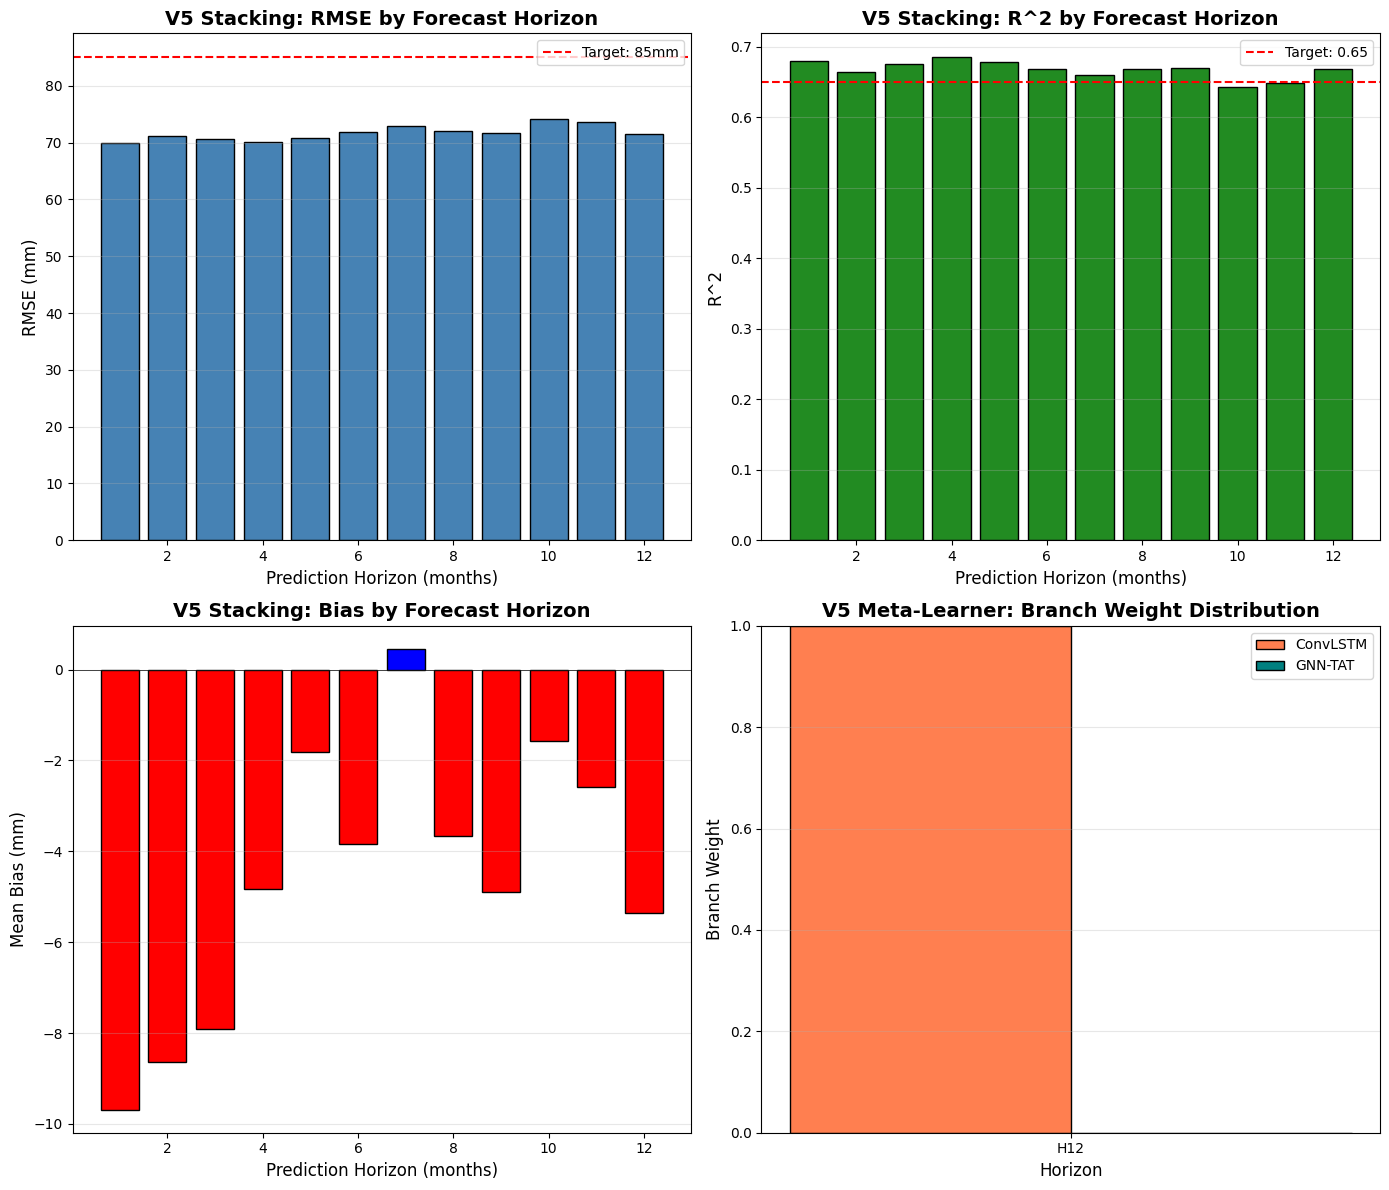


Visualization saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V5_GNN_ConvLSTM_Stacking/v5_results_summary.png (700 DPI)


In [18]:
# =============================================================================
# SECTION 9: RESULTS VISUALIZATION (700 DPI)
# =============================================================================

def plot_v5_results(metrics_df: pd.DataFrame, experiment_state: Dict, output_dir: Path):
    """Generate V5 results visualizations at 700 DPI."""

    if metrics_df is None or len(metrics_df) == 0:
        print("No metrics to plot")
        return

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # 1. RMSE by Horizon
    ax1 = axes[0, 0]
    horizons = sorted(metrics_df['H'].unique())
    rmse_by_h = metrics_df.groupby('H')['RMSE'].mean()
    ax1.bar(rmse_by_h.index, rmse_by_h.values, color='steelblue', edgecolor='black')
    ax1.set_xlabel('Prediction Horizon (months)', fontsize=12)
    ax1.set_ylabel('RMSE (mm)', fontsize=12)
    ax1.set_title('V5 Stacking: RMSE by Forecast Horizon', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)

    # Add target line
    ax1.axhline(y=85, color='red', linestyle='--', label='Target: 85mm')
    ax1.legend()

    # 2. R^2 by Horizon
    ax2 = axes[0, 1]
    r2_by_h = metrics_df.groupby('H')['R^2'].mean()
    ax2.bar(r2_by_h.index, r2_by_h.values, color='forestgreen', edgecolor='black')
    ax2.set_xlabel('Prediction Horizon (months)', fontsize=12)
    ax2.set_ylabel('R^2', fontsize=12)
    ax2.set_title('V5 Stacking: R^2 by Forecast Horizon', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)

    # Add target line
    ax2.axhline(y=0.65, color='red', linestyle='--', label='Target: 0.65')
    ax2.legend()

    # 3. Bias by Horizon
    ax3 = axes[1, 0]
    bias_by_h = metrics_df.groupby('H')['mean_bias_mm'].mean()
    colors = ['red' if b < 0 else 'blue' for b in bias_by_h.values]
    ax3.bar(bias_by_h.index, bias_by_h.values, color=colors, edgecolor='black')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax3.set_xlabel('Prediction Horizon (months)', fontsize=12)
    ax3.set_ylabel('Mean Bias (mm)', fontsize=12)
    ax3.set_title('V5 Stacking: Bias by Forecast Horizon', fontsize=14, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)

    # 4. Branch Weights Evolution
    ax4 = axes[1, 1]

    # Extract branch weights from experiment state
    horizon_labels = []
    w_convlstm = []
    w_gnn = []

    for h_key, results in experiment_state['results'].items():
        if 'metrics' in results and 'branch_weights' in results['metrics']:
            horizon_labels.append(h_key)
            w_convlstm.append(results['metrics']['branch_weights']['w_convlstm'])
            w_gnn.append(results['metrics']['branch_weights']['w_gnn'])

    x = np.arange(len(horizon_labels))
    width = 0.35

    ax4.bar(x - width/2, w_convlstm, width, label='ConvLSTM', color='coral', edgecolor='black')
    ax4.bar(x + width/2, w_gnn, width, label='GNN-TAT', color='teal', edgecolor='black')

    ax4.set_xlabel('Horizon', fontsize=12)
    ax4.set_ylabel('Branch Weight', fontsize=12)
    ax4.set_title('V5 Meta-Learner: Branch Weight Distribution', fontsize=14, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(horizon_labels)
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    ax4.set_ylim(0, 1)

    plt.tight_layout()

    # Save at 700 DPI
    fig_path = output_dir / 'v5_results_summary.png'
    fig.savefig(fig_path, dpi=700, bbox_inches='tight', facecolor='white')
    plt.show()

    print(f"\nVisualization saved to: {fig_path} (700 DPI)")

# Generate visualizations
plot_v5_results(metrics_df, experiment_state, OUTPUT_ROOT)

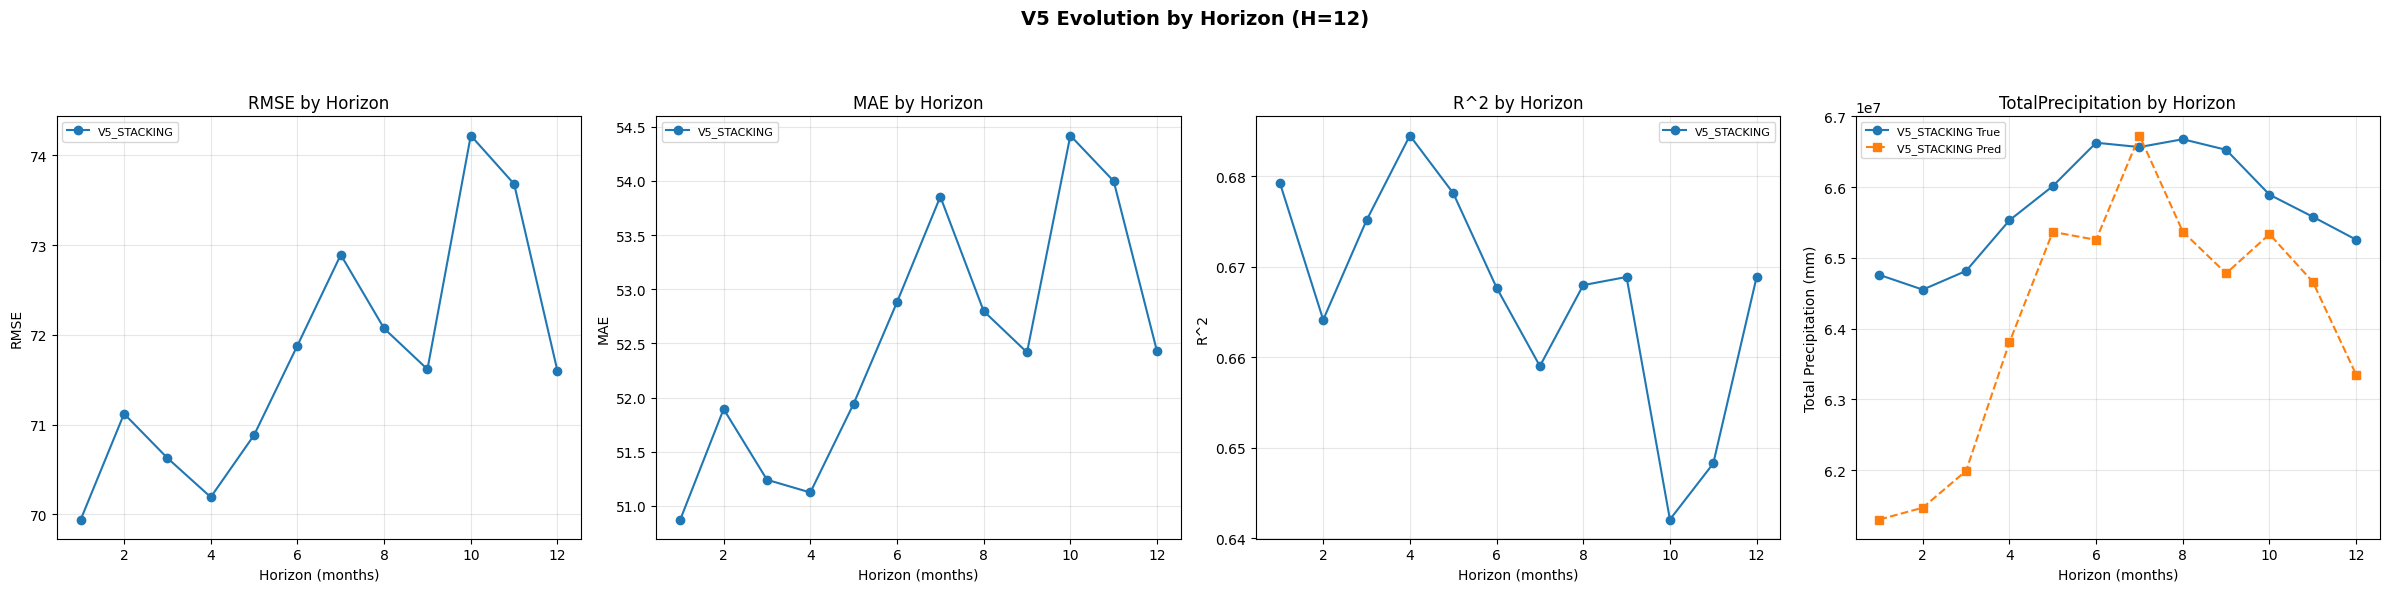

Evolution plot saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V5_GNN_ConvLSTM_Stacking/comparisons/v5_evolution_h12.png


In [19]:
# =============================================================================
# SECTION 9.1: EVOLUTION BY HORIZON (V2/V3 STYLE)
# =============================================================================

COMP_DIR = OUTPUT_ROOT / 'comparisons'
COMP_DIR.mkdir(parents=True, exist_ok=True)


def plot_v5_evolution_by_horizon(metrics_df: pd.DataFrame, output_dir: Path):
    if metrics_df is None or metrics_df.empty:
        print('No metrics to plot for evolution panels')
        return

    metrics = ['RMSE', 'MAE', 'R^2']
    has_tp = 'TotalPrecipitation' in metrics_df.columns and 'TotalPrecipitation_Pred' in metrics_df.columns
    if has_tp:
        metrics.append('TotalPrecipitation')

    for total_h in sorted(metrics_df['TotalHorizon'].unique()):
        sub_df = metrics_df[metrics_df['TotalHorizon'] == total_h].copy()
        if sub_df.empty:
            continue

        fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), 6))
        if len(metrics) == 1:
            axes = [axes]

        for metric, ax in zip(metrics, axes):
            if metric != 'TotalPrecipitation':
                data = sub_df.groupby(['H', 'Model'])[metric].mean().unstack()
                data.plot(ax=ax, marker='o')
                ax.set_ylabel(metric)
            else:
                data_true = sub_df.groupby(['H', 'Model'])['TotalPrecipitation'].mean().unstack()
                data_pred = sub_df.groupby(['H', 'Model'])['TotalPrecipitation_Pred'].mean().unstack()
                for model in data_true.columns:
                    ax.plot(data_true.index, data_true[model], marker='o', label=f'{model} True')
                    ax.plot(data_pred.index, data_pred[model], marker='s', linestyle='--', label=f'{model} Pred')
                ax.set_ylabel('Total Precipitation (mm)')

            ax.set_xlabel('Horizon (months)')
            ax.set_title(f'{metric} by Horizon')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8)

        fig.suptitle(f'V5 Evolution by Horizon (H={total_h})', fontsize=14, fontweight='bold')
        fig.tight_layout(rect=[0, 0, 1, 0.92])
        fig_path = output_dir / f'v5_evolution_h{total_h}.png'
        fig.savefig(fig_path, dpi=150, bbox_inches='tight')
        plt.show()
        print(f'Evolution plot saved to: {fig_path}')


if metrics_df is not None and len(metrics_df) > 0:
    plot_v5_evolution_by_horizon(metrics_df, COMP_DIR)


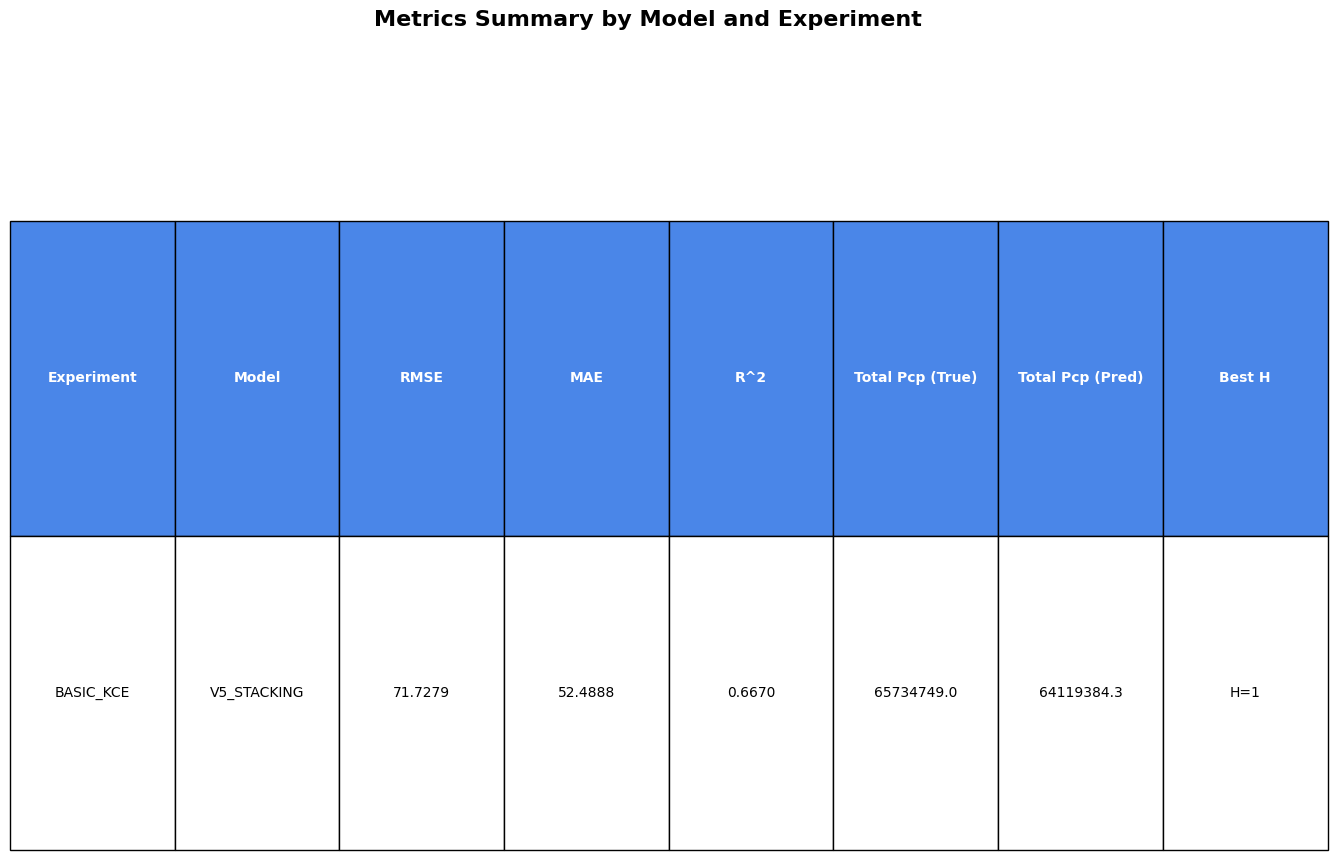

Metrics summary table saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V5_GNN_ConvLSTM_Stacking/comparisons/v5_metrics_summary_table.png


In [20]:
# =============================================================================
# SECTION 9.2: METRICS TABLE (V2/V3 STYLE)
# =============================================================================

COMP_DIR = OUTPUT_ROOT / 'comparisons'
COMP_DIR.mkdir(parents=True, exist_ok=True)


def plot_v5_metrics_table(metrics_df: pd.DataFrame, output_dir: Path):
    if metrics_df is None or metrics_df.empty:
        print('No metrics available to build summary table')
        return

    has_tp = 'TotalPrecipitation' in metrics_df.columns and 'TotalPrecipitation_Pred' in metrics_df.columns

    summary_data = []
    experiments = metrics_df['Experiment'].unique()
    models = metrics_df['Model'].unique()
    headers = ['Experiment', 'Model', 'RMSE', 'MAE', 'R^2', 'Total Pcp (True)', 'Total Pcp (Pred)', 'Best H']

    for exp in experiments:
        for model in models:
            sub = metrics_df[(metrics_df['Experiment'] == exp) & (metrics_df['Model'] == model)]
            if sub.empty:
                continue
            avg_rmse = sub['RMSE'].mean()
            avg_mae = sub['MAE'].mean()
            avg_r2 = sub['R^2'].mean()
            if has_tp:
                avg_tp_t = sub['TotalPrecipitation'].mean()
                avg_tp_p = sub['TotalPrecipitation_Pred'].mean()
            else:
                avg_tp_t = float('nan')
                avg_tp_p = float('nan')
            best_h = sub.loc[sub['RMSE'].idxmin(), 'H']
            summary_data.append([
                exp, model,
                f'{avg_rmse:.4f}', f'{avg_mae:.4f}', f'{avg_r2:.4f}',
                f'{avg_tp_t:.1f}' if has_tp else 'n/a',
                f'{avg_tp_p:.1f}' if has_tp else 'n/a',
                f'H={best_h}'
            ])

    fig, ax = plt.subplots(figsize=(17, 10))
    ax.axis('off')
    table = ax.table(cellText=summary_data, colLabels=headers, cellLoc='center', loc='center', bbox=[0, 0, 1, 0.85])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.15, 1.8)

    for j in range(len(headers)):
        table[(0, j)].set_facecolor('#4a86e8')
        table[(0, j)].set_text_props(weight='bold', color='white')

    fig.suptitle('Metrics Summary by Model and Experiment', fontsize=16, fontweight='bold', y=0.95)
    plt.subplots_adjust(top=0.85)
    fig_path = output_dir / 'v5_metrics_summary_table.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight', pad_inches=0.5)
    plt.show()

    if summary_data:
        print('Metrics summary table saved to:', fig_path)


if metrics_df is not None and len(metrics_df) > 0:
    plot_v5_metrics_table(metrics_df, COMP_DIR)


Comparison plot saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V5_GNN_ConvLSTM_Stacking/comparisons/model_comparison_v5_stacking.png


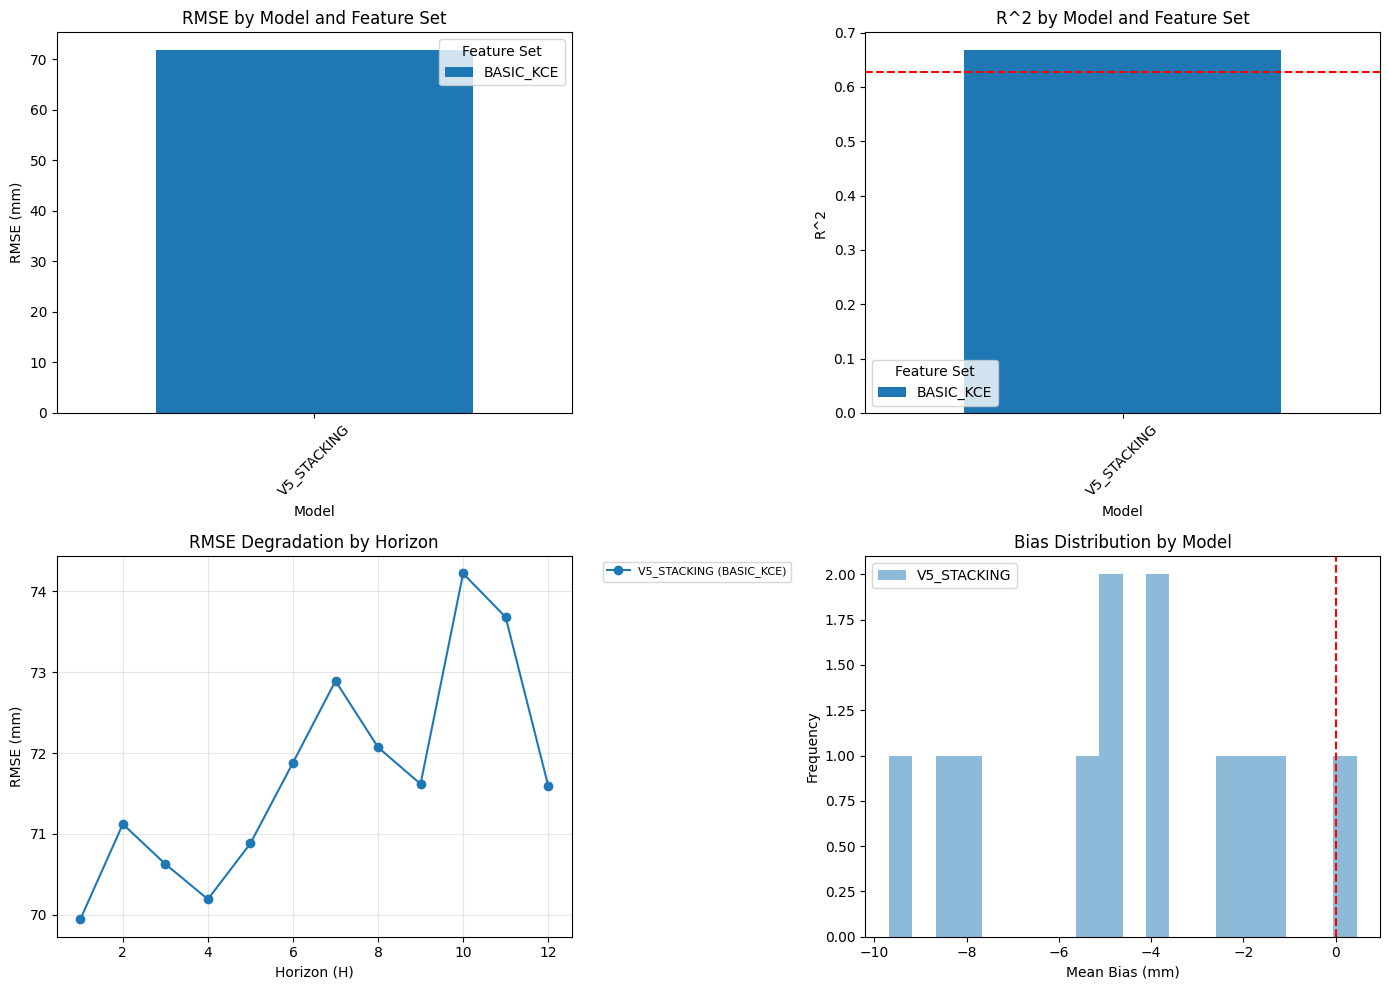

In [21]:
# =============================================================================
# SECTION 9.3: MODEL COMPARISON (V4 STYLE)
# =============================================================================

COMP_DIR = OUTPUT_ROOT / 'comparisons'
COMP_DIR.mkdir(parents=True, exist_ok=True)


def plot_model_comparison_v5(res_df: pd.DataFrame, output_dir: Path):
    if res_df is None or res_df.empty:
        print('No results to plot for model comparison')
        return

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = axes[0, 0]
    pivot_rmse = res_df.groupby(['Model', 'Experiment'])['RMSE'].mean().unstack()
    pivot_rmse.plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_ylabel('RMSE (mm)')
    ax1.set_title('RMSE by Model and Feature Set')
    ax1.legend(title='Feature Set')
    ax1.tick_params(axis='x', rotation=45)

    ax2 = axes[0, 1]
    pivot_r2 = res_df.groupby(['Model', 'Experiment'])['R^2'].mean().unstack()
    pivot_r2.plot(kind='bar', ax=ax2, width=0.8)
    ax2.set_ylabel('R^2')
    ax2.set_title('R^2 by Model and Feature Set')
    ax2.legend(title='Feature Set')
    ax2.tick_params(axis='x', rotation=45)
    ax2.axhline(y=0.628, color='red', linestyle='--', label='V4 Baseline (0.628)')

    ax3 = axes[1, 0]
    for model in res_df['Model'].unique():
        model_data = res_df[res_df['Model'] == model]
        for exp in model_data['Experiment'].unique():
            exp_data = model_data[model_data['Experiment'] == exp]
            ax3.plot(exp_data['H'], exp_data['RMSE'], marker='o', label=f"{model} ({exp})")
    ax3.set_xlabel('Horizon (H)')
    ax3.set_ylabel('RMSE (mm)')
    ax3.set_title('RMSE Degradation by Horizon')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax3.grid(True, alpha=0.3)

    ax4 = axes[1, 1]
    for model in res_df['Model'].unique():
        model_bias = res_df[res_df['Model'] == model]['mean_bias_mm']
        ax4.hist(model_bias, bins=20, alpha=0.5, label=model)
    ax4.axvline(x=0, color='red', linestyle='--')
    ax4.set_xlabel('Mean Bias (mm)')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Bias Distribution by Model')
    ax4.legend()

    plt.tight_layout()

    fig_path = output_dir / 'model_comparison_v5_stacking.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    print(f"Comparison plot saved to: {fig_path}")
    plt.show()


if metrics_df is not None and len(metrics_df) > 0:
    plot_model_comparison_v5(metrics_df, COMP_DIR)


In [22]:
# =============================================================================
# SECTION 9.4: MAP EXPORTS (V2/V3 COMPATIBLE)
# =============================================================================

SHAPE_DIR = BASE_PATH / 'data' / 'input' / 'shapes'


def _load_boyaca_shape(shape_dir: Path):
    if gpd is None:
        print('geopandas not available; overlay disabled')
        return None, None
    if not shape_dir.exists():
        print(f"[WARN] Shape directory not found: {shape_dir}")
        return None, None

    shp_path = shape_dir / 'MGN_Departamento.shp'
    try:
        dept_gdf = gpd.read_file(shp_path)
    except Exception as exc:
        print(f"[WARN] Failed to read shapefile {shp_path}: {exc}")
        return None, None

    if dept_gdf is None or dept_gdf.empty:
        print(f"[WARN] Shapefile is empty: {shp_path}")
        return dept_gdf, None

    col_candidates = [c for c in dept_gdf.columns if c.lower() in {
        'nombre_dpt', 'nombre_dept', 'nombre', 'departamen', 'dpto'
    }]
    boyaca = None
    if col_candidates:
        name_col = col_candidates[0]
        boyaca = dept_gdf[dept_gdf[name_col].astype(str).str.upper().str.contains('BOYACA', na=False)].copy()
    elif len(dept_gdf) == 1:
        boyaca = dept_gdf.copy()
        print('[INFO] No name column found; assuming single feature is Boyaca')
    else:
        print(f"[WARN] Could not identify Boyaca geometry; columns present: {list(dept_gdf.columns)}")

    if boyaca is not None and boyaca.empty:
        print('[WARN] Boyaca geometry not found in shapefile; overlay disabled')
        boyaca = None

    return dept_gdf, boyaca


DEPT_GDF, BOYACA = _load_boyaca_shape(SHAPE_DIR)

MAP_OUT_ROOT = OUTPUT_ROOT / 'map_exports'
PLOT_HORIZONS = CONFIG.enabled_horizons or [CONFIG.horizon]
PLOT_EXPERIMENTS = ['BASIC_KCE']
PLOT_MODELS = ['V5_STACKING']
MAP_SAMPLE_INDEX = CONFIG.map_sample_index
CYCLE_ALL_VAL_WINDOWS = CONFIG.map_cycle_all_val_windows
EXPORT_DPI = CONFIG.map_export_dpi
GIF_FRAME_DURATION = CONFIG.map_gif_duration
MAP_MAX_WINDOWS = None

lats = ds[LAT_DIM].values
lons = ds[LON_DIM].values
EXTENT = [float(lons.min()), float(lons.max()), float(lats.min()), float(lats.max())]


def _load_exports(exp_name: str, model_name: str, horizon: int):
    export_dir = MAP_OUT_ROOT / f'H{horizon}' / exp_name / model_name
    pred_f = export_dir / 'predictions.npy'
    targ_f = export_dir / 'targets.npy'
    meta_f = export_dir / 'metadata.json'
    if not (pred_f.exists() and targ_f.exists() and meta_f.exists()):
        return None, None, None, None
    y_pred = np.load(pred_f)
    y_true = np.load(targ_f)
    meta = json.loads(meta_f.read_text())
    if y_pred.ndim == 5:
        y_pred = y_pred[..., 0]
    if y_true.ndim == 5:
        y_true = y_true[..., 0]
    return y_pred, y_true, meta, export_dir


def _plot_triplet(ax, data, title, cmap, vmin=None, vmax=None):
    im = ax.imshow(data, origin='lower', extent=EXTENT, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])
    return im


def plot_maps_v5():
    if not MAP_OUT_ROOT.exists():
        print(f"Map export root not found: {MAP_OUT_ROOT}")
        return
    if imageio is None:
        print('imageio not available; GIF export disabled')

    for horizon in PLOT_HORIZONS:
        for exp_name in PLOT_EXPERIMENTS:
            for model_name in PLOT_MODELS:
                y_pred, y_true, meta, export_dir = _load_exports(exp_name, model_name, horizon)
                if y_pred is None:
                    print(f"[SKIP] {exp_name} - {model_name} - H{horizon}: exports not found")
                    continue

                if CYCLE_ALL_VAL_WINDOWS:
                    indices_to_plot = range(len(y_true))
                else:
                    idx = MAP_SAMPLE_INDEX if MAP_SAMPLE_INDEX >= 0 else (len(y_true) - 1)
                    idx = max(min(idx, len(y_true) - 1), 0)
                    indices_to_plot = [idx]

                if MAP_MAX_WINDOWS is not None:
                    indices_to_plot = list(indices_to_plot)[:MAP_MAX_WINDOWS]

                forecast_dates = meta.get('forecast_dates', [])
                if not forecast_dates and meta.get('val_indices'):
                    forecast_dates = _forecast_dates(ds, meta['val_indices'], CONFIG.input_window, horizon)

                frame_count = 0
                gif_path = export_dir / f'{model_name}_H{horizon}.gif'
                writer = None

                for idx in indices_to_plot:
                    sample_dates = forecast_dates[idx] if idx < len(forecast_dates) else []
                    for h in range(min(horizon, len(sample_dates) or horizon)):
                        real = y_true[idx, h]
                        pred = y_pred[idx, h]
                        err = np.abs(pred - real) / (np.abs(real) + 1e-6) * 100.0

                        fig, axes = plt.subplots(1, 3, figsize=(14, 4.5), constrained_layout=True)
                        date_label = sample_dates[h] if h < len(sample_dates) else f'H{h + 1}'
                        im0 = _plot_triplet(axes[0], real, f'Real {date_label}', 'Blues')
                        im1 = _plot_triplet(axes[1], pred, f'{model_name} H{h + 1} {date_label}', 'Blues')
                        im2 = _plot_triplet(axes[2], np.clip(err, 0, 100), f'MAPE% {model_name} H{h + 1} {date_label}', 'Reds', vmin=0, vmax=100)
                        if BOYACA is not None:
                            try:
                                BOYACA.boundary.plot(ax=axes[0], color='k', linewidth=0.8)
                                BOYACA.boundary.plot(ax=axes[1], color='k', linewidth=0.8)
                                BOYACA.boundary.plot(ax=axes[2], color='k', linewidth=0.8)
                            except Exception as exc:
                                print(f"[WARN] shapefile overlay failed: {exc}")

                        cbar0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
                        cbar0.set_label('Precipitation (mm)', rotation=270, labelpad=12)
                        cbar1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
                        cbar1.set_label('Precipitation (mm)', rotation=270, labelpad=12)
                        cbar2 = fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
                        cbar2.set_label('MAPE (%)', rotation=270, labelpad=12)

                        title = f'{exp_name} | {model_name} | H{horizon} | {date_label}'
                        fig.suptitle(title, fontsize=12)

                        export_dir.mkdir(parents=True, exist_ok=True)
                        png_path = export_dir / f'{model_name}_H{horizon}_{date_label}.png'
                        fig.savefig(png_path, dpi=EXPORT_DPI)
                        plt.close(fig)

                        if imageio is not None:
                            frame = imageio.imread(png_path)
                            if writer is None:
                                writer = imageio.get_writer(gif_path, mode='I', duration=GIF_FRAME_DURATION, loop=0)
                            writer.append_data(frame)
                            del frame

                        frame_count += 1
                        del real, pred, err

                if writer is not None:
                    writer.close()

                print(f"[OK] {exp_name} - {model_name} - H{horizon}: saved {frame_count} frames to {export_dir}")


if getattr(CONFIG, 'generate_map_plots', True):
    plot_maps_v5()
else:
    print('Map plot generation disabled')


[INFO] No name column found; assuming single feature is Boyaca
[OK] BASIC_KCE - V5_STACKING - H12: saved 12 frames to /content/drive/MyDrive/ml_precipitation_prediction/models/output/V5_GNN_ConvLSTM_Stacking/map_exports/H12/BASIC_KCE/V5_STACKING


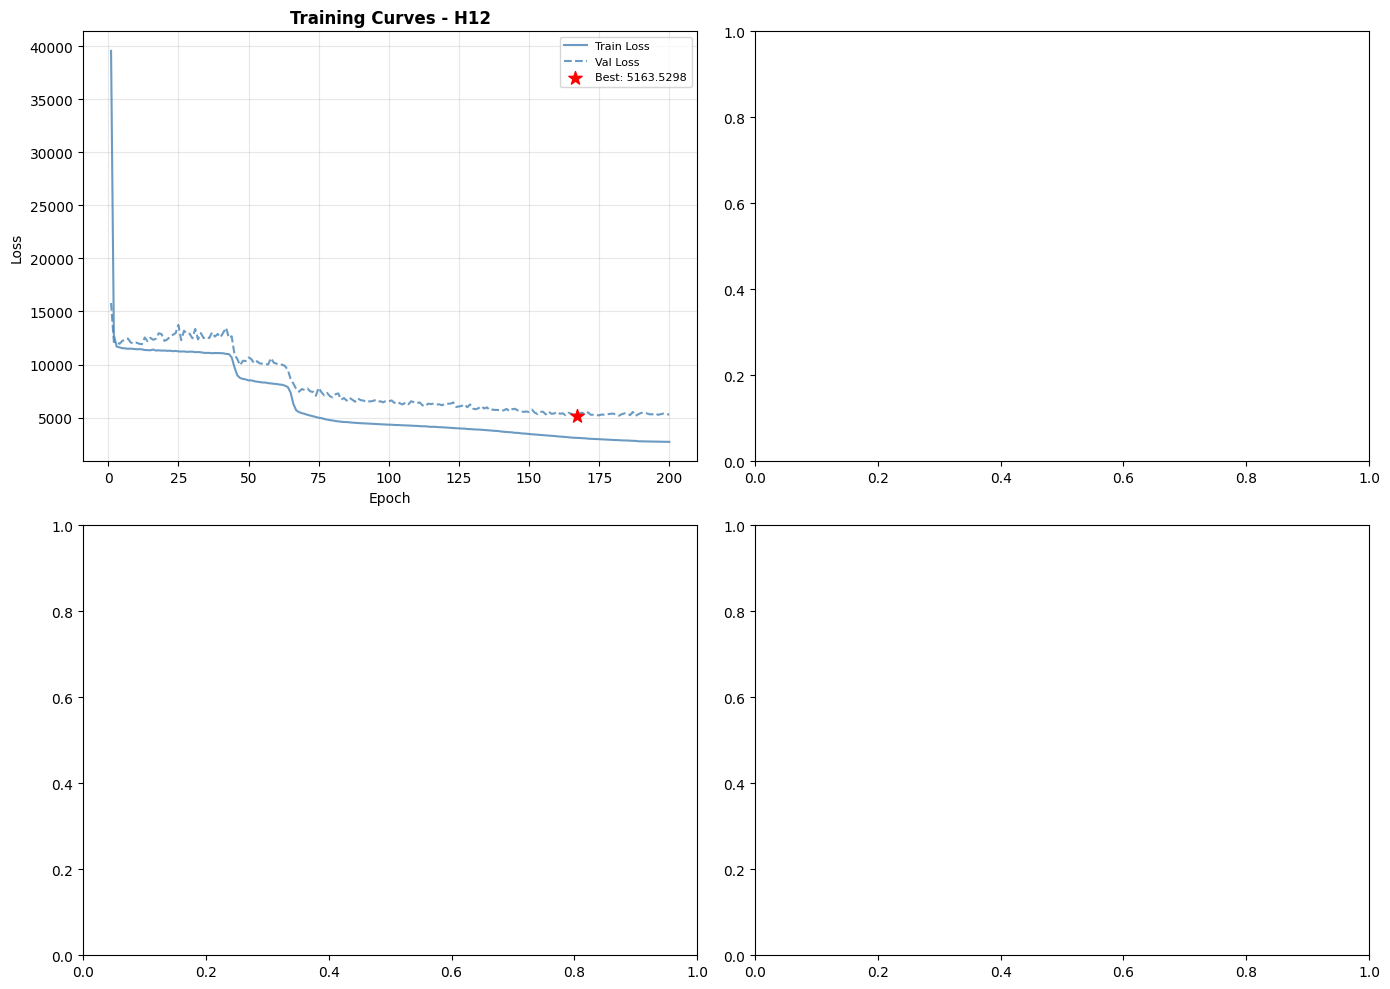

Training curves saved to: /content/drive/MyDrive/ml_precipitation_prediction/models/output/V5_GNN_ConvLSTM_Stacking/v5_training_curves.png (700 DPI)


In [23]:
# =============================================================================
# SECTION 9.2: TRAINING CURVES VISUALIZATION
# =============================================================================

def plot_training_curves(experiment_state: Dict, output_dir: Path):
    """Plot training curves for all horizons."""

    n_horizons = len(experiment_state['results'])
    if n_horizons == 0:
        print("No training results to plot")
        return

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    colors = ['steelblue', 'coral', 'forestgreen', 'purple']

    for idx, (h_key, results) in enumerate(experiment_state['results'].items()):
        if idx >= 4:
            break

        ax = axes[idx]

        # Load training log
        h_num = h_key.replace('H', '')
        log_path = output_dir / f'h{h_num}' / 'BASIC_KCE' / 'training_metrics' / f'v5_stacking_training_log_h{h_num}.csv'

        if log_path.exists():
            log_df = pd.read_csv(log_path)

            ax.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss', color=colors[idx], alpha=0.8)
            ax.plot(log_df['epoch'], log_df['val_loss'], label='Val Loss', color=colors[idx], linestyle='--', alpha=0.8)

            # Mark best epoch
            best_epoch = results['history']['best_epoch'] + 1
            best_val = results['history']['best_val_loss']
            ax.scatter([best_epoch], [best_val], color='red', s=100, zorder=5, marker='*', label=f'Best: {best_val:.4f}')

        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel('Loss', fontsize=10)
        ax.set_title(f'Training Curves - {h_key}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)

    plt.tight_layout()

    # Save at 700 DPI
    fig_path = output_dir / 'v5_training_curves.png'
    fig.savefig(fig_path, dpi=700, bbox_inches='tight', facecolor='white')
    plt.show()

    print(f"Training curves saved to: {fig_path} (700 DPI)")

# Plot training curves
plot_training_curves(experiment_state, OUTPUT_ROOT)

## 10. Summary and Next Steps

In [24]:
# =============================================================================
# SECTION 10: SUMMARY AND RESULTS
# =============================================================================

print("\n" + "="*70)
print("V5 GNN-ConvLSTM STACKING - EXPERIMENT SUMMARY")
print("="*70)

# Print configuration
print("\n[Configuration]")
print(f"  Light Mode: {CONFIG.light_mode}")
if CONFIG.light_mode:
    print(f"  Grid Size: {CONFIG.light_grid_size}x{CONFIG.light_grid_size}")
print(f"  GNN Type: {CONFIG.gnn_type}")
print(f"  Horizons: {CONFIG.enabled_horizons}")
print(f"  Epochs: {CONFIG.epochs}")
print(f"  Batch Size: {CONFIG.batch_size}")

# Print results summary
if metrics_df is not None and len(metrics_df) > 0:
    print("\n[Results Summary]")
    print("-"*70)
    print(metrics_df[['TotalHorizon', 'H', 'RMSE', 'MAE', 'R^2', 'mean_bias_mm']].to_string(index=False))
    print("-"*70)

    # Overall averages
    print("\n[Overall Averages]")
    print(f"  RMSE: {metrics_df['RMSE'].mean():.2f} mm (Target: < 85 mm)")
    print(f"  MAE: {metrics_df['MAE'].mean():.2f} mm")
    print(f"  R2: {metrics_df['R^2'].mean():.4f} (Target: > 0.65)")
    print(f"  Bias: {metrics_df['mean_bias_mm'].mean():.2f} mm")

# Print branch weights
print("\n[Branch Weights (Meta-Learner)]")
for h_key, results in experiment_state['results'].items():
    if 'metrics' in results and 'branch_weights' in results['metrics']:
        weights = results['metrics']['branch_weights']
        print(f"  {h_key}: ConvLSTM={weights['w_convlstm']:.1%}, GNN={weights['w_gnn']:.1%}")

# Quality checks
print("\n[Quality Checks]")
for h_key, results in experiment_state['results'].items():
    qc = results.get('quality_checks', {})
    issues = qc.get('issues', [])
    status = 'OK' if not issues else f"WARN: {', '.join(issues)}"
    print(f"  {h_key}: {status}")

# Output files
print("\n[Output Files]")
print(f"  Output Directory: {OUTPUT_ROOT}")
for path in OUTPUT_ROOT.glob('*'):
    if path.is_file():
        print(f"  - {path.name}")

# Next steps
print("\n[Next Steps]")
if CONFIG.light_mode:
    print("  1. Set light_mode=False for full grid validation (61x65)")
    print("  2. Run full experiments on Colab GPU")
print("  3. Compare results with V4 baseline (R2=0.628, RMSE=92.12mm)")



V5 GNN-ConvLSTM STACKING - EXPERIMENT SUMMARY

[Configuration]
  Light Mode: False
  GNN Type: GAT
  Horizons: [12]
  Epochs: 200
  Batch Size: 4

[Results Summary]
----------------------------------------------------------------------
 TotalHorizon  H      RMSE       MAE      R^2  mean_bias_mm
           12  1 69.943550 50.872852 0.679261     -9.687714
           12  2 71.122032 51.893036 0.664122     -8.635040
           12  3 70.628387 51.240105 0.675120     -7.919189
           12  4 70.192871 51.122562 0.684484     -4.832367
           12  5 70.884369 51.942524 0.678115     -1.811874
           12  6 71.881973 52.880280 0.667675     -3.847824
           12  7 72.892784 53.855347 0.659002      0.457031
           12  8 72.071808 52.798180 0.667952     -3.661713
           12  9 71.617592 52.416790 0.668855     -4.892899
           12 10 74.221138 54.419853 0.642050     -1.564163
           12 11 73.681213 53.998459 0.648245     -2.576981
           12 12 71.597534 52.425575 0.6688

In [25]:
# =============================================================================
# SECTION 10.2: CLEANUP
# =============================================================================

# Memory cleanup
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU Memory freed. Current usage: {torch.cuda.memory_allocated() / 1e6:.1f} MB")

print("\nNotebook execution completed successfully.")

GPU Memory freed. Current usage: 76.7 MB

Notebook execution completed successfully.
